# Our Custom Implementation of the AER Architecture and Related Experiments

## Overview and Motivation

The Auto-Encoder with Regression (AER) method was originally implemented by the Orion team as part of the `orion-ml` library. Their reference implementation relies on **Keras** and **TensorFlow**, and is designed to provide an end-to-end anomaly detection pipeline for time series data. While this implementation is faithful to the original paper, it presents several practical limitations when used in modern experimentation environments.

Firstly, a major drawback encountered during this project is related to **environment compatibility**. At the time of this work, Google Colab has migrated to **Python 3.12**, whereas the `orion-ml` library is only compatible with Python versions **3.8 to 3.11**, due to its dependency on TensorFlow. As a result, the official AER implementation cannot be executed directly on Colab. This restriction forces users to rely on **local execution**, typically through Conda environments or other environment-management tools, which significantly limits accessibility, reproducibility, and collaborative experimentation.

Secondly, given the architectural complexity of the AER method, the model involves a number of **design choices and hyperparameters**, including window sizes, latent dimensions, loss weighting, reconstruction metrics, smoothing strategies, and thresholding mechanisms. From an initial inspection of the Orion API, we found that many of these components are either **abstracted away** or **difficult to modify**, making it less intuitive to experiment with alternative configurations or adapt the method to different types of time series data.

Thirdly, we were interested in evaluating how well the AER framework performs when its implementation is derived **solely from the methodological descriptions provided in the original article**, rather than relying on an existing codebase. This serves both as a validation of the paper’s clarity and as a means of gaining deeper insight into the method’s design choices.

Motivated by these observations, we implemented the **entire AER model from scratch**, strictly following the explanations and equations presented in the paper. Our implementation is written in **PyTorch**, which not only enables compatibility with **modern Python versions (including Python 3.12)** but also allows seamless execution on **Google Colab**, thereby improving accessibility and collaborative usage.

Beyond faithfully reproducing the original method, we extend the AER framework by offering **multiple anomaly score constructions and thresholding strategies**, allowing users to select the most appropriate configuration for their data. This flexibility makes the model more **versatile**, **interpretable**, and **generalizable** across a wide range of univariate time series datasets.

In the following sections, we present our complete, from-scratch implementation of the AER method and demonstrate its application to both synthetic and real-world time series data.


In [1]:
import sys, site
print(sys.version)
site.getsitepackages()

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


['/usr/local/lib/python3.12/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.12/dist-packages']

### The Full Pipeline at a Glance

The overall AER pipeline follows a sequential and modular workflow, which can be summarized as follows:

- **Input time series**  
  The pipeline starts from a univariate time series representing the observed signal to be analyzed.

- **Preprocessing (imputation and scaling)**  
  Missing values are imputed, and the signal is scaled to a fixed range to ensure numerical stability during training.

- **Sliding window construction**  
  The preprocessed signal is segmented into overlapping sliding windows, which serve as the basic input units for the AER model.

- **AER model training**  
  The AER architecture is trained to jointly learn prediction-based and reconstruction-based representations of normal time series behavior.

- **AER model prediction**  
  Once trained, the model produces forward and reverse predictions, as well as reconstructed sequences, for each sliding window.

- **Regression error computation**  
  Prediction errors are computed by comparing the predicted values with the true observations, capturing deviations in temporal predictability.

- **Reconstruction error computation**  
  Reconstruction errors are computed by comparing the reconstructed sequences with the original signal, capturing deviations from learned normal patterns.

- **Score combination**  
  Prediction-based and reconstruction-based anomaly scores are combined using a user-selected strategy to form a final anomaly score sequence.

- **Thresholding and interval extraction**  
  The final anomaly scores are post-processed using a thresholding routine to identify anomalous time intervals.

- **Visualization**  
  The input signal, reconstructed signal, anomaly scores, and detected anomaly intervals are visualized to facilitate interpretation and qualitative analysis.


In [2]:
# ============================================================
# AER (Auto-Encoder with Bi-directional Regression) in PyTorch
#
# Includes:
#  1) Imputation (linear here in our implementation)
#  2) Optional detrending (least-squares line, linear for the instance)
#  3) Scaling (MinMax to [-1, 1]) + inverse available
#  4) Sliding windows (n+2)
#  5) BiLSTM encoder + BiLSTM decoder
#  6) Training loop (3-headed loss: reverse/regression/reconstruction/forward)
#  7) Regression score (bi-directional) with masking + EWMA
#  8) Reconstruction score (point / area / dtw) with masking + EWMA
#  9) Score combination (pred / rec / sum / mult)
# 10) Threshold + anomaly interval extraction (AD)
# 11) Optional visualization
#
# Dependencies: numpy, torch, matplotlib
# Works well on Python 3.10–3.12 (PyTorch-supported), CPU or GPU.
# ============================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Optional plotting
try:
    import matplotlib.pyplot as plt
    _HAS_PLT = True
except Exception:
    _HAS_PLT = False


# 1) Preprocessing: impute + detrend + scale

# impute
def impute_linear(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float).copy()
    n = len(x)
    mask = np.isnan(x)
    if not mask.any():
        return x

    idx = np.arange(n)
    good = ~mask

    # if all nan, fall back to zeros
    if good.sum() == 0:
        return np.zeros_like(x)

    # if nan at boundaries, np.interp fills using nearest good values
    x[mask] = np.interp(idx[mask], idx[good], x[good])
    return x


# detrend
def detrend_least_squares(x: np.ndarray) -> np.ndarray:
    """
    Fit x_t ≈ a t + b (least squares) and subtract fitted trend.
    """
    x = np.asarray(x, dtype=float)
    t = np.arange(len(x), dtype=float)
    t_mean = t.mean()
    x_mean = x.mean()
    denom = np.sum((t - t_mean) ** 2)
    if denom < 1e-12:
        return x - x_mean
    a = np.sum((t - t_mean) * (x - x_mean)) / denom
    b = x_mean - a * t_mean
    trend = a * t + b
    return x - trend

# scale
class MinMaxScaler1D:
    """
    Lightweight MinMax scaler for 1D arrays.
    Default target range: [-1, 1] to match common LSTM practice in AER pipeline.
    """
    def __init__(self, feature_range=(-1.0, 1.0), eps=1e-12):
        self.a, self.b = float(feature_range[0]), float(feature_range[1])
        self.eps = eps
        self.data_min_ = None
        self.data_max_ = None

    def fit(self, x: np.ndarray):
        x = np.asarray(x, dtype=float)
        self.data_min_ = float(np.min(x))
        self.data_max_ = float(np.max(x))
        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        x = np.asarray(x, dtype=float)
        mn, mx = self.data_min_, self.data_max_
        denom = (mx - mn) if (mx - mn) > self.eps else self.eps
        z = (x - mn) / denom
        return z * (self.b - self.a) + self.a

    def inverse_transform(self, z: np.ndarray) -> np.ndarray:
        z = np.asarray(z, dtype=float)
        mn, mx = self.data_min_, self.data_max_
        denom = (mx - mn) if (mx - mn) > self.eps else self.eps
        x = (z - self.a) / (self.b - self.a)  # back to [0,1]
        return x * denom + mn

# return the processed signals
def preprocess_signal(
    x: np.ndarray,
    do_impute: bool = True,
    do_detrend: bool = False,
    scale_range=(-1.0, 1.0)
):
    """
    Returns:
      x_raw (float array)
      x_proc (after impute/detrend)
      x_scaled (scaled to scale_range)
      scaler (fitted MinMaxScaler1D)
    """
    x_raw = np.asarray(x, dtype=float).copy()
    x_proc = x_raw.copy()

    if do_impute:
      x_proc = impute_linear(x_proc)

    if do_detrend:
        x_proc = detrend_least_squares(x_proc)

    scaler = MinMaxScaler1D(feature_range=scale_range).fit(x_proc)
    x_scaled = scaler.transform(x_proc)

    return x_raw, x_proc, x_scaled, scaler


# 2) Window construction: AER windows of length n+2

def make_aer_windows(x_scaled: np.ndarray, n: int):
    """
    Windows:
      w_i = [x_{i-1}, x_i, ..., x_{i+n-1}, x_{i+n}]  length n+2
    Returns:
      W: (N, n+2)
      idx: (N,) the start i of the reconstruction segment x_i..x_{i+n-1}
    """
    x_scaled = np.asarray(x_scaled, dtype=float)
    T = len(x_scaled)
    windows, indices = [], []
    for i in range(1, T - n):
        windows.append(x_scaled[i-1:i+n+1])
        indices.append(i)
    return np.asarray(windows, dtype=float), np.asarray(indices, dtype=int)


class AERWindowDataset(Dataset):
    """
    Produces:
      X  : (n, 1)            the internal segment (window[1:-1])
      ry : scalar            window[0]
      y  : (n,)              window[1:-1]
      fy : scalar            window[-1]
      i  : int               mapping index (start of recon segment)
    """
    def __init__(self, x_scaled: np.ndarray, n: int):
        W, idx = make_aer_windows(x_scaled, n)
        self.W = W
        self.idx = idx
        self.n = n

    def __len__(self):
        return self.W.shape[0]

    def __getitem__(self, k):
        w = self.W[k]
        i = int(self.idx[k])

        X = w[1:-1]                      # (n,)
        ry = w[0]                        # scalar
        y = w[1:-1]                      # (n,)
        fy = w[-1]                       # scalar

        # Return tensors
        X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)     # (n,1)
        ry_t = torch.tensor(ry, dtype=torch.float32)                 # ()
        y_t  = torch.tensor(y, dtype=torch.float32)                  # (n,)
        fy_t = torch.tensor(fy, dtype=torch.float32)                 # ()
        i_t  = torch.tensor(i, dtype=torch.long)

        return X_t, ry_t, y_t, fy_t, i_t


# 3) AER model in PyTorch: BiLSTM encoder + BiLSTM decoder

class AERBiLSTM(nn.Module):
    """
    Encoder: BiLSTM over length n -> latent vector of size 2*units
    Decoder: repeat latent over length (n+2), BiLSTM -> per-time output -> (n+2)
    Outputs:
      ry_hat: (B,)          output[0]
      y_hat : (B, n)        output[1:-1]
      fy_hat: (B,)          output[-1]
    """
    def __init__(self, n: int, units: int = 30):
        super().__init__()
        self.n = n
        self.units = units

        self.enc = nn.LSTM(
            input_size=1,
            hidden_size=units,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.dec = nn.LSTM(
            input_size=2*units,
            hidden_size=units,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Project BiLSTM decoder outputs (2*units) -> scalar value per time step
        self.proj = nn.Linear(2*units, 1)

    def forward(self, X):
        """
        X: (B, n, 1)
        returns ry_hat (B,), y_hat (B,n), fy_hat (B,)
        """
        B = X.size(0)

        # Encoder: take last hidden states of both directions -> (B, 2*units)
        _, (h_n, _) = self.enc(X)
        # h_n: (num_layers*directions=2, B, units)
        h_fwd = h_n[0]               # (B, units)
        h_bwd = h_n[1]               # (B, units)
        z = torch.cat([h_fwd, h_bwd], dim=1)  # (B, 2*units)

        # Repeat latent for decoder over length n+2
        L = self.n + 2
        z_rep = z.unsqueeze(1).repeat(1, L, 1)  # (B, n+2, 2*units)

        dec_out, _ = self.dec(z_rep)           # (B, n+2, 2*units)
        out = self.proj(dec_out).squeeze(-1)   # (B, n+2)

        ry_hat = out[:, 0]                     # (B,)
        y_hat  = out[:, 1:-1]                  # (B, n)
        fy_hat = out[:, -1]                    # (B,)

        return ry_hat, y_hat, fy_hat


# 4) Training loop

def train_aer(
    x_scaled: np.ndarray,
    n: int = 100,
    units: int = 30,
    reg_ratio: float = 0.5,
    lr: float = 1e-3,
    epochs: int = 30,
    batch_size: int = 64,
    device: str = None,
    verbose: bool = True
):
    """
    reg_ratio corresponds to gamma in the paper.
    loss = (gamma/2)*MSE(ry) + (1-gamma)*MSE(recon) + (gamma/2)*MSE(fy)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    ds = AERWindowDataset(x_scaled, n)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)

    model = AERBiLSTM(n=n, units=units).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    for ep in range(1, epochs + 1):
        model.train()
        total = 0.0
        num = 0

        for X, ry, y, fy, _ in dl:
            X = X.to(device)                  # (B,n,1)
            ry = ry.to(device)                # (B,)
            y  = y.to(device)                 # (B,n)
            fy = fy.to(device)                # (B,)

            opt.zero_grad()
            ry_hat, y_hat, fy_hat = model(X)

            loss_ry = mse(ry_hat, ry)
            loss_y  = mse(y_hat, y)
            loss_fy = mse(fy_hat, fy)

            loss = (reg_ratio/2.0) * loss_ry + (1.0 - reg_ratio) * loss_y + (reg_ratio/2.0) * loss_fy
            loss.backward()
            opt.step()

            total += float(loss.item()) * X.size(0)
            num += X.size(0)

        if verbose:
            print(f"epoch {ep:03d}/{epochs:03d} | loss {total / max(num,1):.6f} | device {device}")

    return model, device


# 5) Prediction on all windows (to build scores)

@torch.no_grad()
def predict_aer_windows(model: nn.Module, x_scaled: np.ndarray, n: int, device: str = None, batch_size: int = 256):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    ds = AERWindowDataset(x_scaled, n)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False)

    model.eval()

    ry_list, y_list, fy_list, idx_list = [], [], [], []

    for X, _, _, _, idx in dl:
        X = X.to(device)
        ry_hat, y_hat, fy_hat = model(X)

        ry_list.append(ry_hat.cpu().numpy())
        y_list.append(y_hat.cpu().numpy())
        fy_list.append(fy_hat.cpu().numpy())
        idx_list.append(idx.cpu().numpy())

    ry_hat = np.concatenate(ry_list, axis=0)        # (N,)
    y_hat  = np.concatenate(y_list, axis=0)         # (N,n)
    fy_hat = np.concatenate(fy_list, axis=0)        # (N,)
    idx    = np.concatenate(idx_list, axis=0)       # (N,)

    return ry_hat, y_hat, fy_hat, idx



# 6) Smoothing + masking

def ewma_windowed(scores: np.ndarray, window_frac: float = 0.1) -> np.ndarray:
    """
    EWMA with an effective window length ~ window_frac * T.
    We convert window length L to alpha via the common rule alpha = 2/(L+1).
    """
    s = np.asarray(scores, dtype=float)
    T = len(s)
    L = max(1, int(window_frac * T))
    alpha = 2.0 / (L + 1.0)

    out = np.empty_like(s)
    out[0] = s[0]
    for i in range(1, T):
        out[i] = alpha * s[i] + (1.0 - alpha) * out[i - 1]
    return out


def apply_mask(scores: np.ndarray, m: int, mode: str = "min") -> np.ndarray:
    s = np.asarray(scores, dtype=float).copy()
    if m <= 0:
        return s
    if m >= len(s):
        return s
    if mode == "zero":
        s[:m] = 0.0
    else:
        s[:m] = np.min(s[m:])
    return s


# Paper-faithful Bi-directional prediction anomaly scores (Eq. 1 + Eq. 6)

def regression_scores_paper(
    x_scaled: np.ndarray,
    ry_hat: np.ndarray,
    fy_hat: np.ndarray,
    idx: np.ndarray,
    n: int,
    smooth: bool = True,
    smoothing_window: float = 0.01,
    mask: bool = True,
    m: int = None
) -> np.ndarray:
    """
    Implements the paper’s bi-directional scoring:
      - forward scores at t = i+n  (i = idx)
      - reverse scores at t = i-1  (i = idx)
      - masking: forward first m -> 0 ; reverse first m -> min(reverse)
      - padding: forward prepend n zeros ; reverse append n zeros
      - combine: overlap -> average ; non-overlap -> max   (Eq. 6)
    """
    x_scaled = np.asarray(x_scaled, dtype=float)
    T = len(x_scaled)

    # α_p(t,f) stored into f_base at its true timestamp t
    f_base = np.zeros(T, dtype=float)
    f_count = np.zeros(T, dtype=int)

    for i, f in zip(idx, fy_hat):
        t = int(i + n)
        if 0 <= t < T:
            f_base[t] += abs(x_scaled[t] - f)
            f_count[t] += 1

    # average if multiple preds land on same t (still consistent with α_p definition)
    f_base = np.divide(f_base, np.maximum(f_count, 1))

    # α_p(t,r) stored into r_base at its true timestamp t
    r_base = np.zeros(T, dtype=float)
    r_count = np.zeros(T, dtype=int)

    for i, r in zip(idx, ry_hat):
        t = int(i - 1)
        if 0 <= t < T:
            r_base[t] += abs(x_scaled[t] - r)
            r_count[t] += 1

    r_base = np.divide(r_base, np.maximum(r_count, 1))

    # masking (paper: m defaults to 0.017T in their best setting; keep yours overrideable)
    if mask:
        if m is None:
            m = max(1, int(0.017 * T))
        # forward: first m set to 0
        f_base[:m] = 0.0
        # reverse: first m set to min(reverse) (computed from the rest)
        if m < T:
            r_min = float(np.min(r_base[m:]))
            r_base[:m] = r_min

    # padding to align per paper description
    f = np.concatenate([np.zeros(n, dtype=float), f_base])[:T]        # prepend n zeros
    r = np.concatenate([r_base, np.zeros(n, dtype=float)])[:T]        # append n zeros

    # combine with Eq. (6)
    scores = np.zeros(T, dtype=float)

    # overlap region in the paper is the middle; outside overlap use max
    # We implement exactly the three cases shown in Eq.(6)-style description:
    #   early: use r
    #   middle: average
    #   late: use f
    # Using the indices they describe with masking m:
    early_end = min(T, n + m)             # inclusive end (0-based)
    late_start = max(0, T - n)            # start of late region

    for t in range(T):
        if t <= early_end:
            scores[t] = r[t]
        elif t >= late_start:
            scores[t] = f[t]
        else:
            scores[t] = 0.5 * (f[t] + r[t])

    if smooth:
        scores = ewma_windowed(scores, window_frac=smoothing_window)

    return scores


# 8) Reconstruction scores (point / area / dtw)

# Paper-faithful reconstruction anomaly scores (Eq. 2–4)

# the following dtw distance deviates slightly from its definition
# in the paper, primarily not having the renomalizing factor. This
# does not influence much in what follows as the scales of the dtw
# distance remain almost proportional for all segments as the window
# sizes here are all the same here. We also notice that this version of
# the DTW produces better results.
def dtw_distance(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    n, m = len(a), len(b)
    D = np.full((n + 1, m + 1), np.inf, dtype=float)
    D[0, 0] = 0.0
    for i in range(1, n + 1):
        ai = a[i - 1]
        for j in range(1, m + 1):
            cost = abs(ai - b[j - 1])
            D[i, j] = cost + min(D[i - 1, j], D[i, j - 1], D[i - 1, j - 1])
    return float(D[n, m])

# the following implementation is the paper-faithful implementation of the
# dtw distance. to run experiments with this dtw version, uncomment the following
# block and comment out the block above. Some other small changes in the call to these
# functions might also be required right at the end, no other changes in between

# def dtw_distance(a: np.ndarray, b: np.ndarray) -> float:
#     """
#     Paper-faithful DTW anomaly score:
#     returns (1/Q) * sum_{q=1}^Q c_q
#     where Q is the length of the optimal warping path.
#     """
#     a = np.asarray(a, dtype=float)
#     b = np.asarray(b, dtype=float)

#     n, m = len(a), len(b)

#     # DP tables: cumulative cost and path length
#     D = np.full((n + 1, m + 1), np.inf, dtype=float)
#     L = np.zeros((n + 1, m + 1), dtype=int)

#     D[0, 0] = 0.0
#     L[0, 0] = 0

#     for i in range(1, n + 1):
#         ai = a[i - 1]
#         for j in range(1, m + 1):
#             cost = abs(ai - b[j - 1])

#             # choose predecessor with minimal cumulative cost
#             choices = (
#                 D[i - 1, j],     # vertical
#                 D[i, j - 1],     # horizontal
#                 D[i - 1, j - 1]  # diagonal
#             )
#             k = int(np.argmin(choices))

#             if k == 0:
#                 prev_i, prev_j = i - 1, j
#             elif k == 1:
#                 prev_i, prev_j = i, j - 1
#             else:
#                 prev_i, prev_j = i - 1, j - 1

#             D[i, j] = cost + D[prev_i, prev_j]
#             L[i, j] = L[prev_i, prev_j] + 1

#     # Eq. (4): average cost along optimal warping path
#     return float(D[n, m] / max(L[n, m], 1))


def reconstruction_scores_paper(
    x_scaled: np.ndarray,
    y_hat: np.ndarray,
    idx: np.ndarray,
    n: int,
    rec_error_type: str = "dtw",    # "point" | "area" | "dtw"
    smooth: bool = True,
    smoothing_window: float = 0.01,
    mask: bool = True,
    m: int = None
):
    """
    Paper-faithful reconstruction anomaly score.

    Steps:
      1) Aggregate overlapping reconstructions via MEDIAN -> y[t]
      2) Compute reconstruction error:
         - point: |x_t - y_t|
         - area of |x - y|
         - dtw  : WINDOW-LEVEL DTW, assigned to window, aggregated by median
      3) Mask initial region
      4) EWMA smoothing
    """
    x_scaled = np.asarray(x_scaled, dtype=float)
    T = len(x_scaled)


    # 1) Median-aggregated reconstructed signal

    y = aggregate_reconstruction_median(y_hat, idx, T=T, n=n)


    # 2) Reconstruction error

    pd = np.abs(x_scaled - y)

    if rec_error_type == "point":
        scores = pd

    elif rec_error_type == "area":
        L = max(1, n)
        scores = np.zeros(T, dtype=float)
        for i in range(T):
            a = max(0, i - L)
            b = min(T, i + L + 1)
            scores[i] = float(np.mean(pd[a:b]))

    elif rec_error_type == "dtw":

        # one DTW per reconstruction WINDOW (i, i+n)
        # assigned to that window, overlaps aggregated by MEDIAN

        buckets = [[] for _ in range(T)]

        for k, i in enumerate(idx):
            i = int(i)
            a = i
            b = min(T, i + n)

            d = dtw_distance(x_scaled[a:b], y[a:b])

            for t in range(a, b):
                buckets[t].append(d)

        scores = np.zeros(T, dtype=float)
        for t in range(T):
            if buckets[t]:
                scores[t] = float(np.median(buckets[t]))
            else:
                scores[t] = 0.0

    else:
        raise ValueError('rec_error_type must be one of ["point","area","dtw"]')

    # 3) Masking
    if mask:
        if m is None:
            m = max(1, int(0.01 * T))
        if m < T:
            scores[:m] = float(np.min(scores[m:]))
        else:
            scores[:] = scores[0]

    # 4) Smoothing
    if smooth:
        scores = ewma_windowed(scores, window_frac=smoothing_window)

    return scores, y

# Our implementation which will help us plot the predicted signal
# We are using median here
# Paper-faithful reconstruction aggregation: y_i = median of overlapping reconstructions

def aggregate_reconstruction_median(
    y_hat: np.ndarray,
    idx: np.ndarray,
    T: int,
    n: int
) -> np.ndarray:
    """
    Build a single reconstructed signal y of length T.
    For each time t, collect all reconstructed values y_hat[k, j]
    such that idx[k] + j == t, and set y[t] = median(collection).
    This matches the paper’s described aggregation.
    """
    buckets = [[] for _ in range(T)]

    for k, i in enumerate(idx):
        i = int(i)
        for j in range(n):
            t = i + j
            if 0 <= t < T:
                buckets[t].append(float(y_hat[k, j]))

    y = np.zeros(T, dtype=float)
    for t in range(T):
        if buckets[t]:
            y[t] = float(np.median(buckets[t]))
        else:
            y[t] = 0.0  # uncovered edges

    return y



# 9) Score combination (pred / rec / sum / mult)

def minmax_to_range(x: np.ndarray, lo: float, hi: float, eps: float = 1e-12) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    mn, mx = float(np.min(x)), float(np.max(x))
    denom = (mx - mn) if (mx - mn) > eps else eps
    z = (x - mn) / denom
    return z * (hi - lo) + lo

def combine_scores(
    reg: np.ndarray,
    rec: np.ndarray,
    comb: str = "mult",
    beta: float = 0.5
) -> np.ndarray:
    """
    comb:
      "pred": use reg only
      "rec":  use rec only
      "sum":  minmax to [0,1], then (1-beta)*rec + beta*reg
      "mult": minmax to [1,2], then reg * rec
    """
    reg = np.asarray(reg, dtype=float)
    rec = np.asarray(rec, dtype=float)

    if comb == "pred":
        return reg

    if comb == "rec":
        return rec

    if comb == "sum":
        r1 = minmax_to_range(reg, 0.0, 1.0)
        r2 = minmax_to_range(rec, 0.0, 1.0)
        return (1.0 - beta) * r2 + beta * r1

    if comb == "mult":
        r1 = minmax_to_range(reg, 1.0, 2.0)
        r2 = minmax_to_range(rec, 1.0, 2.0)
        return r1 * r2 # paper mentions beta = 1 by default, but it can be changed here by multiplying the return by beta

    raise ValueError('comb must be one of ["pred","rec","sum","mult"]')


# 10) Thresholding + anomaly intervals (AD)

# Paper-faithful thresholding: local adaptive thresholding + pruning
# howewer the paper is a little ambiguous as to how to pick thresholds
# over overlapping regions, we have therefore used a rather conservative
# heuristic by taking the max over the overlaps, we can also have other approaches

def local_adaptive_thresholding_paper(
    scores: np.ndarray,
    window_frac: float = 1/3,
    step_frac: float = 1/30,
    z: float = 4.0,
    max_len_frac: float = 1.0,
    theta: float = 0.13,
    min_len: int = 5
):
    """
    A simple implementation of the “non-parametric dynamic thresholding” described in the paper:
      - sliding window: compute mean + z*std per window
      - mark points above local threshold
      - merge consecutive points into intervals
      - pruning based on percentage decrease rule (theta)
    """
    s = np.asarray(scores, dtype=float)
    T = len(s)

    W = max(10, int(window_frac * T))
    step = max(1, int(step_frac * T))
    max_len = max(min_len, int(max_len_frac * T))

    # local thresholds (take max over overlaps for conservatism)
    thr = np.full(T, -np.inf, dtype=float)
    for start in range(0, T, step):
        end = min(T, start + W)
        w = s[start:end]
        mu = float(np.mean(w))
        sd = float(np.std(w))
        local = mu + z * sd
        # thr[start:end] = local
        thr[start:end] = np.maximum(thr[start:end], local)

        # here is another alternative for the thresholding which has been commented out
        # thr[start:end] = local


        # w = s[start:end]
        # # reference window: past-only
        # ref_len = max(10, len(w) // 4)
        # w_ref = w[:ref_len]

        # mu = float(np.mean(w_ref))
        # sd = float(np.std(w_ref))
        # local = mu + z * sd
        # thr[start:end] = np.maximum(thr[start:end], local)
        if end == T:
            break

    flags = s > thr

    # build raw intervals
    intervals = []
    i = 0
    while i < T:
        if not flags[i]:
            i += 1
            continue
        j = i
        while j < T and flags[j]:
            j += 1
        if j - i >= min_len:
            intervals.append((i, j))
        i = j

    # merge close intervals if needed (optional; keep conservative)
    merged = []
    for (a, b) in intervals:
        if not merged:
            merged.append([a, b])
        else:
            if a <= merged[-1][1]:
                merged[-1][1] = max(merged[-1][1], b)
            else:
                merged.append([a, b])
    intervals = [(a, b) for a, b in merged]

    # enforce max length
    trimmed = []
    for (a, b) in intervals:
        if b - a > max_len:
            # split into chunks
            k = a
            while k < b:
                kk = min(b, k + max_len)
                if kk - k >= min_len:
                    trimmed.append((k, kk))
                k = kk
        else:
            trimmed.append((a, b))
    intervals = trimmed

    # pruning by “percentage decrease” heuristic:
    # sort by max score in interval; keep until the next drop is <= theta
    if not intervals:
        return thr, []

    interval_peaks = [float(np.max(s[a:b])) for (a, b) in intervals]
    order = np.argsort(interval_peaks)[::-1]
    intervals_sorted = [intervals[k] for k in order]
    peaks_sorted = [interval_peaks[k] for k in order]

    keep = []
    for k in range(len(peaks_sorted)):
        keep.append(intervals_sorted[k])
        if k + 1 < len(peaks_sorted):
            if peaks_sorted[k] <= 0:
                continue
            drop = (peaks_sorted[k] - peaks_sorted[k + 1]) / peaks_sorted[k]
            if drop <= theta:
                # stop: remaining are reclassified as normal
                break

    # return intervals with mean score for plotting consistency
    out = [(a, b, float(np.mean(s[a:b]))) for (a, b) in keep]
    return thr, out


# the following block of code is also an implementation of the function above, but
# the max over thresholds is not imlemented in it, it is much more closer to the
# general description of the thresholding strategy in the paper. Uncomment it to use.
# Some necessary modifications to the function calls (done at the end of the code block)
# might be required.

# def local_adaptive_thresholding_paper(
#     scores: np.ndarray,
#     window_frac: float = 1/3,
#     step_frac: float = 1/30,
#     z: float = 4.0,
#     theta: float = 0.13
# ):
#     """
#     Paper-minimal implementation of the locally adaptive thresholding
#     described in the AER paper (Hundman et al.).

#     Returns:
#       thr : adaptive threshold per time index
#       out : list of (start, end, mean_score) anomalous intervals
#     """
#     s = np.asarray(scores, dtype=float)
#     T = len(s)

#     W = int(window_frac * T)
#     step = int(step_frac * T)

#
#     # 1) Sliding-window adaptive thresholds
#
#     thr = np.full(T, -np.inf, dtype=float)

#     for start in range(0, T - W + 1, step):
#         end = start + W
#         w = s[start:end]

#         mu = float(np.mean(w))
#         sd = float(np.std(w))
#         local_thr = mu + z * sd

#         # assign threshold for this window
#         thr[start:end] = np.maximum(thr[start:end], local_thr)

#
#     # 2) Flag anomalous points
#
#     flags = s > thr

#
#     # 3) Build anomalous intervals
#
#     intervals = []
#     i = 0
#     while i < T:
#         if not flags[i]:
#             i += 1
#             continue
#         j = i
#         while j < T and flags[j]:
#             j += 1
#         intervals.append((i, j))
#         i = j

#     if not intervals:
#         return thr, []

#
#     # 4) Pruning via percentage decrease rule
#
#     peaks = np.array([np.max(s[a:b]) for (a, b) in intervals])
#     order = np.argsort(peaks)[::-1]

#     intervals_sorted = [intervals[k] for k in order]
#     peaks_sorted = peaks[order]

#     keep = []
#     for k in range(len(peaks_sorted)):
#         keep.append(intervals_sorted[k])

#         if k + 1 < len(peaks_sorted):
#             drop = (peaks_sorted[k] - peaks_sorted[k + 1]) / peaks_sorted[k]
#             if drop <= theta:
#                 break

#
#     # 5) Output format (for plotting / consistency)

#     out = [(a, b, float(np.mean(s[a:b]))) for (a, b) in keep]

#     return thr, out


# local thresholding without paper-described pruning
def local_adaptive_thresholding_no_pruning(
    scores: np.ndarray,
    window_frac: float = 1/3,
    step_frac: float = 1/30,
    z: float = 4.0,
    max_len_frac: float = 1.0,
    min_len: int = 5
):
    """
    Non-parametric dynamic thresholding (paper-style), WITHOUT pruning:
      - sliding window: compute mean + z*std per window
      - take max threshold over overlapping windows
      - mark points above threshold
      - merge consecutive anomalous points into intervals
      - enforce minimum and maximum interval length
      - NO percentage-decrease pruning
    """
    s = np.asarray(scores, dtype=float)
    T = len(s)

    W = max(10, int(window_frac * T))
    step = max(1, int(step_frac * T))
    max_len = max(min_len, int(max_len_frac * T))

    # Local thresholds

    thr = np.full(T, -np.inf, dtype=float)
    for start in range(0, T, step):
        end = min(T, start + W)
        w = s[start:end]

        mu = float(np.mean(w))
        sd = float(np.std(w))
        local = mu + z * sd

        thr[start:end] = np.maximum(thr[start:end], local)

        if end == T:
            break

    flags = s > thr

    # Build raw intervals
    intervals = []
    i = 0
    while i < T:
        if not flags[i]:
            i += 1
            continue
        j = i
        while j < T and flags[j]:
            j += 1
        if j - i >= min_len:
            intervals.append((i, j))
        i = j

    # Merge overlapping / adjacent intervals
    merged = []
    for (a, b) in intervals:
        if not merged:
            merged.append([a, b])
        else:
            if a <= merged[-1][1]:
                merged[-1][1] = max(merged[-1][1], b)
            else:
                merged.append([a, b])
    intervals = [(a, b) for a, b in merged]

    # Enforce maximum interval length
    trimmed = []
    for (a, b) in intervals:
        if b - a > max_len:
            k = a
            while k < b:
                kk = min(b, k + max_len)
                if kk - k >= min_len:
                    trimmed.append((k, kk))
                k = kk
        else:
            trimmed.append((a, b))
    intervals = trimmed

    # NO PRUNING return all detected intervals
    out = [(a, b, float(np.mean(s[a:b]))) for (a, b) in intervals]
    return thr, out


# Global thresholding with pruning
def global_thresholding_paper_style(
    scores: np.ndarray,
    z: float = 4.0,
    max_len_frac: float = 1.0,
    theta: float = 0.13,
    min_len: int = 5
):
    """
    Paper-style post-processing with a GLOBAL threshold:
      - threshold = median(scores) + z * std(scores)
      - all remaining steps identical to the paper
    """
    s = np.asarray(scores, dtype=float)
    T = len(s)

    max_len = max(min_len, int(max_len_frac * T))

    # GLOBAL threshold (ONLY change compared to local version)
    mu = float(np.median(s))        # changed from mean
    sd = float(np.std(s))           # standard deviation as usual
    thr = np.full(T, mu + z * sd)

    flags = s > thr

    # build raw intervals
    intervals = []
    i = 0
    while i < T:
        if not flags[i]:
            i += 1
            continue
        j = i
        while j < T and flags[j]:
            j += 1
        if j - i >= min_len:
            intervals.append((i, j))
        i = j

    # merge overlapping intervals
    merged = []
    for (a, b) in intervals:
        if not merged:
            merged.append([a, b])
        else:
            if a <= merged[-1][1]:
                merged[-1][1] = max(merged[-1][1], b)
            else:
                merged.append([a, b])
    intervals = [(a, b) for a, b in merged]

    # enforce max length
    trimmed = []
    for (a, b) in intervals:
        if b - a > max_len:
            k = a
            while k < b:
                kk = min(b, k + max_len)
                if kk - k >= min_len:
                    trimmed.append((k, kk))
                k = kk
        else:
            trimmed.append((a, b))
    intervals = trimmed

    # pruning by percentage decrease rule (theta)
    if not intervals:
        return thr, []

    interval_peaks = [float(np.max(s[a:b])) for (a, b) in intervals]
    order = np.argsort(interval_peaks)[::-1]
    intervals_sorted = [intervals[k] for k in order]
    peaks_sorted = [interval_peaks[k] for k in order]

    keep = []
    for k in range(len(peaks_sorted)):
        keep.append(intervals_sorted[k])
        if k + 1 < len(peaks_sorted):
            if peaks_sorted[k] <= 0:
                continue
            drop = (peaks_sorted[k] - peaks_sorted[k + 1]) / peaks_sorted[k]
            if drop <= theta:
                break

    out = [(a, b, float(np.mean(s[a:b]))) for (a, b) in keep]
    return thr, out

# global thresholding no pruning
def global_thresholding_no_pruning(
    scores: np.ndarray,
    z: float = 4.0,
    max_len_frac: float = 1.0,
    min_len: int = 5
):
    """
    Global thresholding with:
      - threshold = median(scores) + z * std(scores)
      - NO pruning / percentage-decrease rule
      - interval construction exactly as in the paper otherwise
    """
    s = np.asarray(scores, dtype=float)
    T = len(s)

    max_len = max(min_len, int(max_len_frac * T))

    # Global threshold
    mu = float(np.median(s))
    sd = float(np.std(s))
    thr = np.full(T, mu + z * sd, dtype=float)

    flags = s > thr


    # Build raw intervals

    intervals = []
    i = 0
    while i < T:
        if not flags[i]:
            i += 1
            continue
        j = i
        while j < T and flags[j]:
            j += 1
        if j - i >= min_len:
            intervals.append((i, j))
        i = j

    # Merge overlapping / adjacent intervals

    merged = []
    for (a, b) in intervals:
        if not merged:
            merged.append([a, b])
        else:
            if a <= merged[-1][1]:
                merged[-1][1] = max(merged[-1][1], b)
            else:
                merged.append([a, b])
    intervals = [(a, b) for a, b in merged]

    # Enforce maximum interval length
    trimmed = []
    for (a, b) in intervals:
        if b - a > max_len:
            k = a
            while k < b:
                kk = min(b, k + max_len)
                if kk - k >= min_len:
                    trimmed.append((k, kk))
                k = kk
        else:
            trimmed.append((a, b))
    intervals = trimmed

    # Return intervals (no pruning)

    out = [(a, b, float(np.mean(s[a:b]))) for (a, b) in intervals]
    return thr, out



def plot_results(
    x_raw: np.ndarray,
    x_proc: np.ndarray,
    y_recon_signal: np.ndarray,
    scores: np.ndarray,
    intervals,
    title: str = "AER (PyTorch)"
):
    """
    Plot:
      1) Raw vs processed signal
      2) Paper-faithful AER reconstructed signal (median-aggregated)
      3) Final anomaly score with detected intervals

    IMPORTANT:
    - y_recon_signal MUST already be aggregated using MEDIAN over overlaps
    - No reconstruction aggregation is performed here
    """

    if not _HAS_PLT:
        print("matplotlib not available; skipping plot.")
        return

    x_raw = np.asarray(x_raw, dtype=float)
    x_proc = np.asarray(x_proc, dtype=float)
    y_recon_signal = np.asarray(y_recon_signal, dtype=float)
    scores = np.asarray(scores, dtype=float)

    T = len(x_raw)
    t = np.arange(T)

    fig, ax = plt.subplots(3, 1, figsize=(13, 9), sharex=True)

    # 1) Raw vs processed signal
    ax[0].plot(t, x_raw, alpha=0.35, label="raw")
    ax[0].plot(t, x_proc, linewidth=1.5, label="processed")
    ax[0].set_title(title)
    ax[0].legend(loc="upper right")

    # 2) AER reconstructed signal (paper-faithful)
    ax[1].plot(t, x_proc, alpha=0.35, label="processed input")
    ax[1].plot(
        t,
        y_recon_signal,
        linewidth=2.0,
        label="AER reconstruction (median)"
    )

    for (a, b, _) in intervals:
        ax[1].axvspan(a, b, alpha=0.2)

    ax[1].legend(loc="upper right")
    ax[1].set_title("AER reconstructed signal")

    # 3) Final anomaly score
    ax[2].plot(t, scores, label="anomaly score")

    for (a, b, _) in intervals:
        ax[2].axvspan(a, b, alpha=0.2)

    ax[2].legend(loc="upper right")
    ax[2].set_title("Final anomaly score")

    plt.tight_layout()
    plt.show()




# 12) Full pipeline wrapper

def run_aer_pipeline_pytorch(
    x: np.ndarray,
    n: int = 100,
    units: int = 30,
    reg_ratio: float = 0.5,
    lr: float = 1e-3,
    epochs: int = 30,
    batch_size: int = 64,
    do_impute: bool = True,
    do_detrend: bool = False,
    m: int = None,
    # mask_mode: str = "min",
    rec_error_type: str = "dtw",      # "point" | "area" | "dtw"
    comb: str = "mult",              # "pred" | "rec" | "sum" | "mult"
    beta: float = 0.5,
    min_len: int = 5,
    device: str = None,
    visualize: bool = True,
    thresholding: str = "local_no_pruning"
):
    # Step 1–3: preprocess
    x_raw, x_proc, x_scaled, scaler = preprocess_signal(
        x,
        do_impute=do_impute,
        do_detrend=do_detrend,
        scale_range=(-1.0, 1.0)
    )

    # Step 4: train
    model, device_used = train_aer(
        x_scaled=x_scaled,
        n=n,
        units=units,
        reg_ratio=reg_ratio,
        lr=lr,
        epochs=epochs,
        batch_size=batch_size,
        device=device,
        verbose=True
    )

    # Step 5: predict windows
    ry_hat, y_hat, fy_hat, idx = predict_aer_windows(
        model=model,
        x_scaled=x_scaled,
        n=n,
        device=device_used,
        batch_size=max(128, batch_size)
    )

    # Step 6: regression score
    reg = regression_scores_paper(
        x_scaled=x_scaled,
        ry_hat=ry_hat,
        fy_hat=fy_hat,
        idx=idx,
        n=n,
        m=m
    )


    # Step 7: reconstruction score
    rec, y_recon_signal = reconstruction_scores_paper(
        x_scaled=x_scaled,
        y_hat=y_hat,
        idx=idx,
        n=n,
        rec_error_type=rec_error_type,
        m=m
    )



    # Step 8: combine
    scores = combine_scores(reg, rec, comb=comb, beta=beta)

    # Step 9: threshold + intervals
    # 4 different types of thresholding one can do

    if thresholding == "local_pruning":
        thr_curve, intervals = local_adaptive_thresholding_paper(
            scores,
            window_frac=1/3,
            step_frac=1/30,
            z=4.0,
            theta=0.13,
            min_len=min_len
        )

    elif thresholding == "local_no_pruning":
        thr_curve, intervals = local_adaptive_thresholding_no_pruning(
            scores,
            window_frac=1/3,
            step_frac=1/30,
            z=3.0,
            min_len=min_len
        )

    elif thresholding == "global_pruning":
        thr_curve, intervals = global_thresholding_paper_style(
            scores,
            z=3.0,
            theta=0.13,
            min_len=min_len
        )

    elif thresholding == "global_no_pruning":
        thr_curve, intervals = global_thresholding_no_pruning(
            scores,
            z=3.0,
            min_len=min_len
        )

    else:
        raise ValueError(
            "thresholding must be one of: "
            "'local_pruning', 'local_no_pruning', "
            "'global_pruning', 'global_no_pruning'"
        )



    # Step 10: visualize
    if visualize:
        plot_results(
            x_raw=x_raw,
            x_proc=x_proc,
            y_recon_signal=y_recon_signal,
            scores=scores,
            intervals=intervals,
            title=f"AER PyTorch | detrended | rec={rec_error_type} comb={comb}"
    )


    return {
        "model": model,
        "device": device_used,
        "scaler": scaler,
        "x_raw": x_raw,
        "x_processed": x_proc,
        "x_scaled": x_scaled,
        "ry_hat": ry_hat,
        "y_hat": y_hat,
        "fy_hat": fy_hat,
        "idx": idx,
        "reg_scores": reg,
        "rec_scores": rec,
        "combined_scores": scores,
        "threshold": thr_curve,
        "intervals": intervals
    }


Trying out the AER implementation with the multiplicative anomaly score ("mult").

epoch 001/010 | loss 0.137643 | device cpu
epoch 002/010 | loss 0.031513 | device cpu
epoch 003/010 | loss 0.016279 | device cpu
epoch 004/010 | loss 0.012124 | device cpu
epoch 005/010 | loss 0.009742 | device cpu
epoch 006/010 | loss 0.009141 | device cpu
epoch 007/010 | loss 0.008289 | device cpu
epoch 008/010 | loss 0.008156 | device cpu
epoch 009/010 | loss 0.007879 | device cpu
epoch 010/010 | loss 0.008043 | device cpu


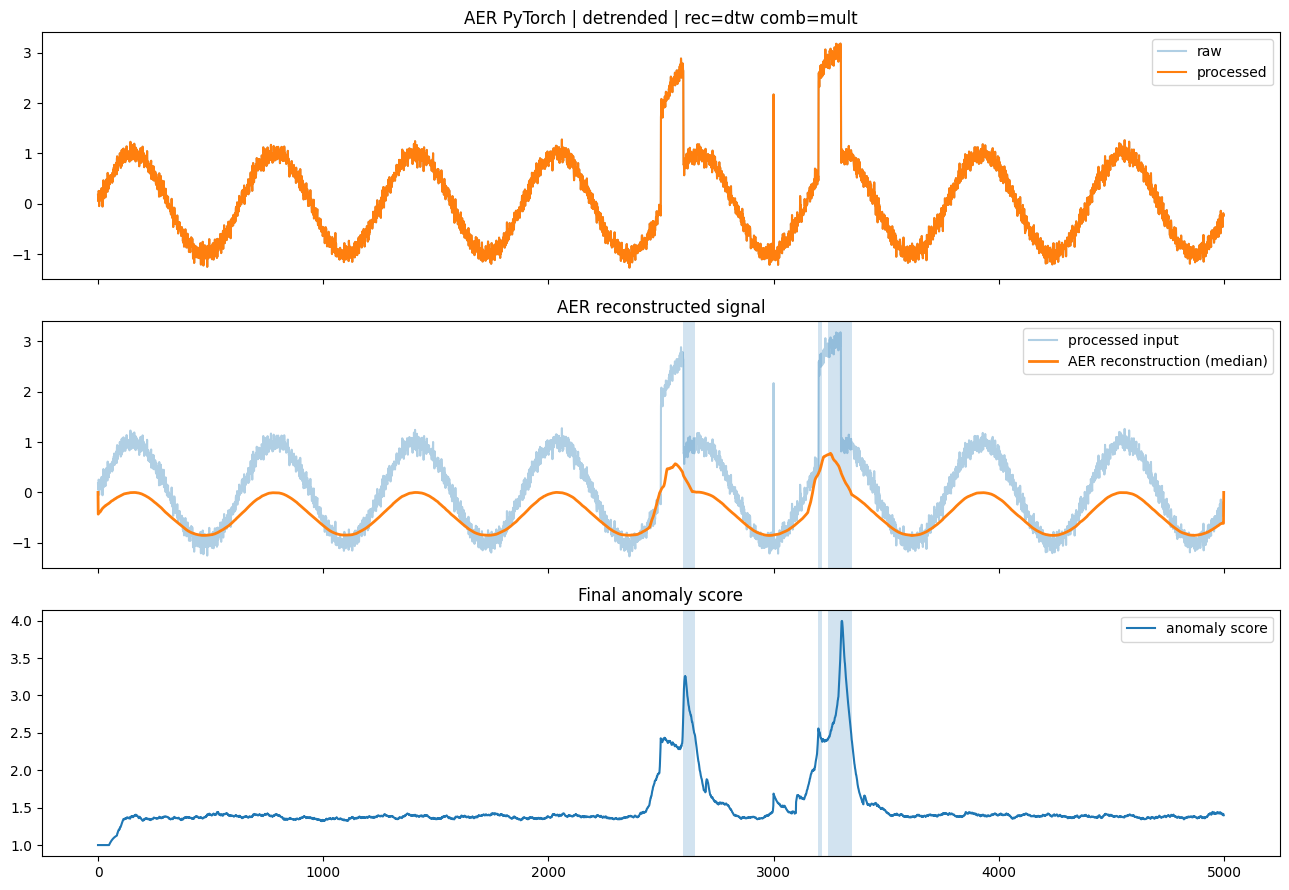

threshold: [2.41964729 2.41964729 2.41964729 ... 2.41964729 2.41964729 2.41964729]
first intervals: [(2596, 2653, 2.8273688702851287), (3198, 3213, 2.4831169510895443), (3242, 3347, 2.977559588361717)]


In [3]:
# 13) Example usage
np.random.seed(0)

T = 5000
x = np.sin(np.linspace(0, 50, T)) + 0.1 * np.random.randn(T)
x[2500:2600] += 2.0
x[3200:3300] += 2.0
x[3000] += 3            # injected anomaly
x[100] = np.nan              # missing value example

results = run_aer_pipeline_pytorch(
    x=x,
    n=100,
    units=30,
    reg_ratio=0.5,
    lr=1e-3,
    epochs=10,
    batch_size=64,
    do_impute=True,
    do_detrend=False,
    rec_error_type="dtw",     # "point" | "area" | "dtw"
    comb="mult",              # "pred" | "rec" | "sum" | "mult"
    #q=0.995,
    min_len=10,
    visualize=True,
    thresholding = "global_no_pruning"
)

print("threshold:", results["threshold"])
print("first intervals:", results["intervals"][:5])

Trying out the AER implementation with the convex sum anomaly score ("sum").

epoch 001/010 | loss 0.076912 | device cpu
epoch 002/010 | loss 0.020084 | device cpu
epoch 003/010 | loss 0.012993 | device cpu
epoch 004/010 | loss 0.010929 | device cpu
epoch 005/010 | loss 0.009734 | device cpu
epoch 006/010 | loss 0.008066 | device cpu
epoch 007/010 | loss 0.008028 | device cpu
epoch 008/010 | loss 0.007630 | device cpu
epoch 009/010 | loss 0.007783 | device cpu
epoch 010/010 | loss 0.007806 | device cpu


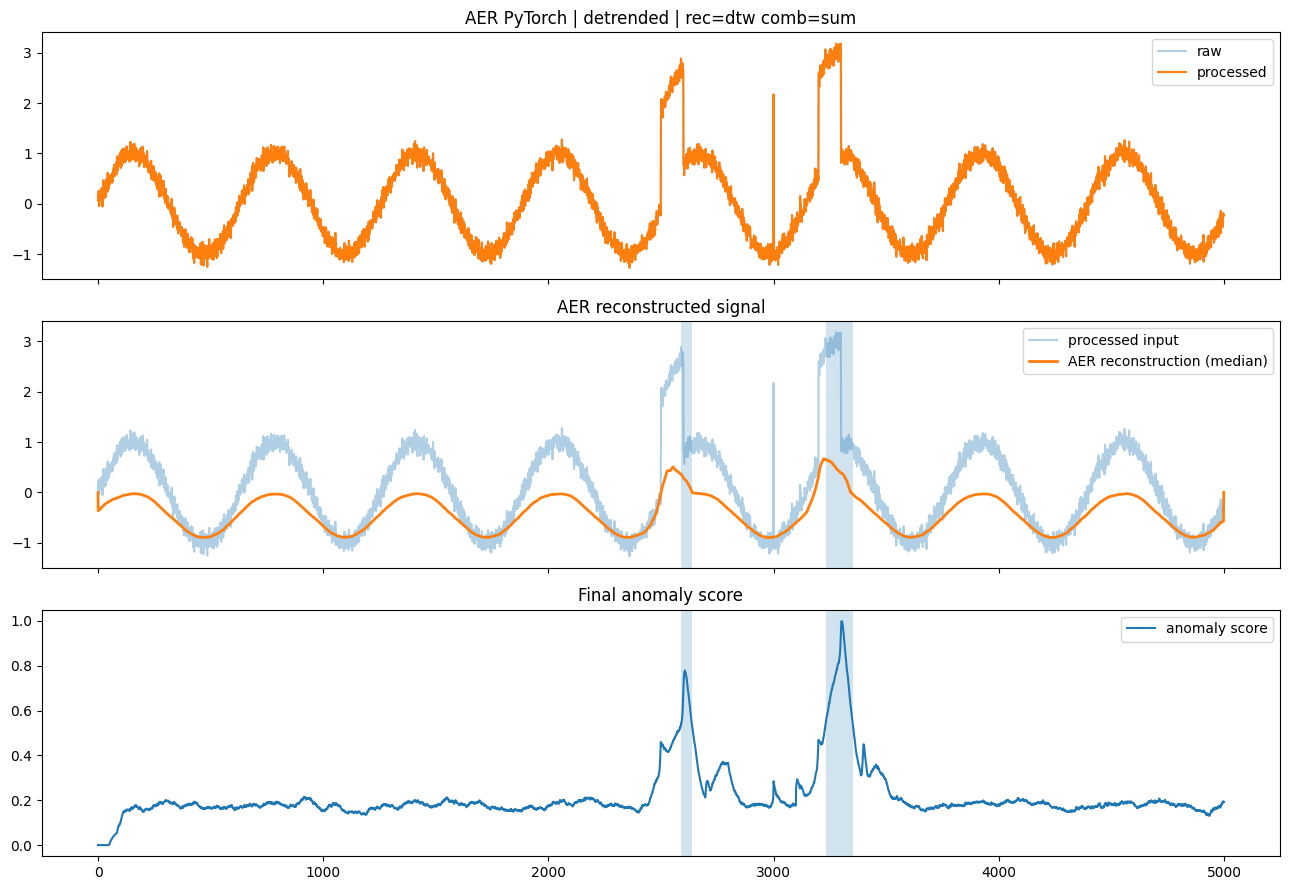

threshold: [0.53941678 0.53941678 0.53941678 ... 0.53941678 0.53941678 0.53941678]
first intervals: [(2590, 2637, 0.6673671544114902), (3231, 3352, 0.7463259148649886)]


In [4]:

np.random.seed(0)

T = 5000
x = np.sin(np.linspace(0, 50, T)) + 0.1 * np.random.randn(T)
x[2500:2600] += 2.0
x[3200:3300] += 2.0
x[3000] += 3            # injected anomaly
x[100] = np.nan              # missing value example

results = run_aer_pipeline_pytorch(
    x=x,
    n=100,
    units=30,
    reg_ratio=0.5,
    lr=1e-3,
    epochs=10,
    batch_size=64,
    do_impute=True,
    do_detrend=False,
    rec_error_type="dtw",     # "point" | "area" | "dtw"
    comb="sum",              # "pred" | "rec" | "sum" | "mult"
    min_len=10,
    visualize=True,
    thresholding = "global_no_pruning"
)

print("threshold:", results["threshold"])
print("first intervals:", results["intervals"][:5])

Trying out the AER implementation with the predictive anomaly score ("pred").

epoch 001/010 | loss 0.093587 | device cpu
epoch 002/010 | loss 0.022746 | device cpu
epoch 003/010 | loss 0.013022 | device cpu
epoch 004/010 | loss 0.011127 | device cpu
epoch 005/010 | loss 0.009767 | device cpu
epoch 006/010 | loss 0.008952 | device cpu
epoch 007/010 | loss 0.008479 | device cpu
epoch 008/010 | loss 0.008245 | device cpu
epoch 009/010 | loss 0.007786 | device cpu
epoch 010/010 | loss 0.007491 | device cpu


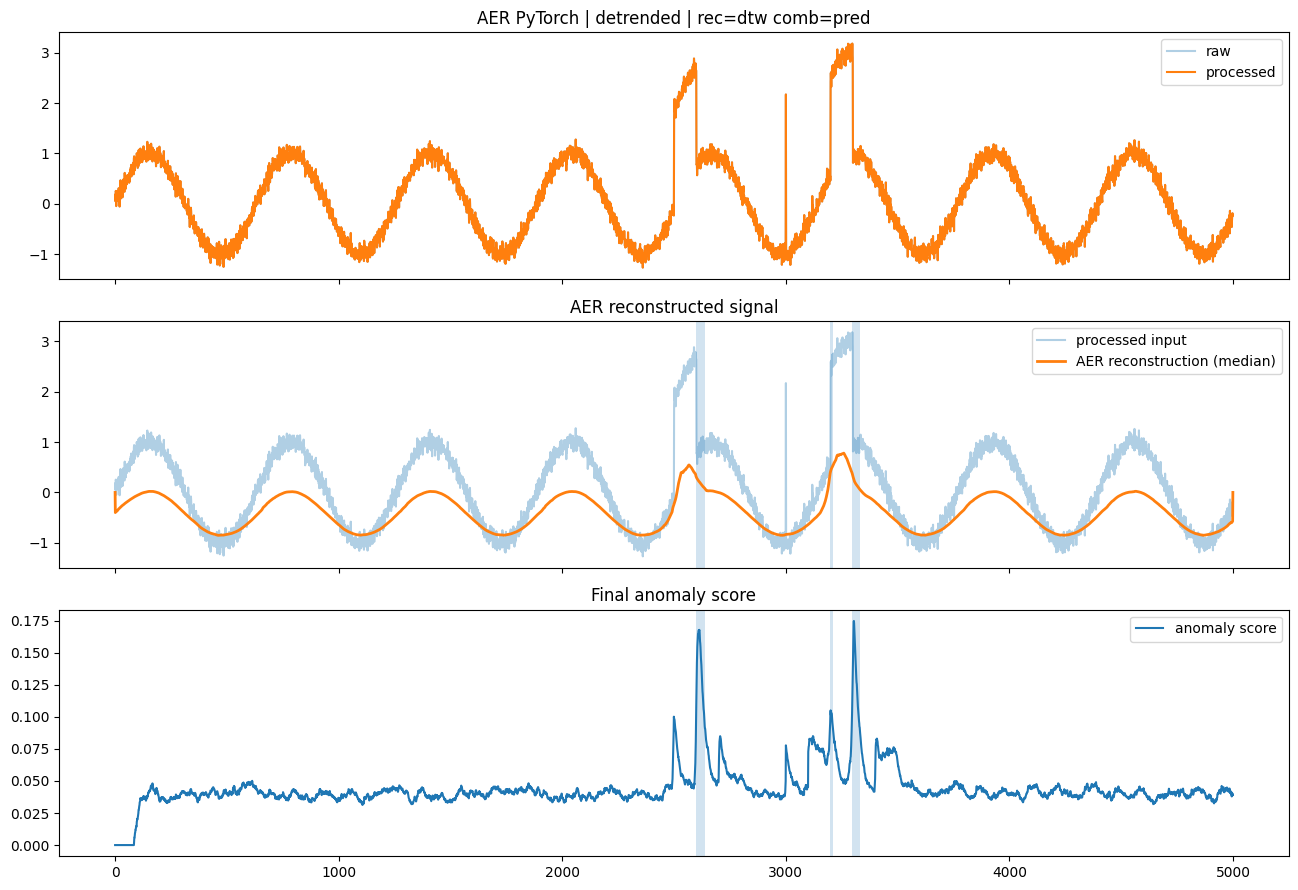

threshold: [0.09016471 0.09016471 0.09016471 ... 0.09016471 0.09016471 0.09016471]
first intervals: [(2598, 2640, 0.13423332262720422), (3197, 3212, 0.09807475050057034), (3295, 3331, 0.12982819965767015)]


In [5]:
np.random.seed(0)

T = 5000
x = np.sin(np.linspace(0, 50, T)) + 0.1 * np.random.randn(T)
x[2500:2600] += 2.0
x[3200:3300] += 2.0
x[3000] += 3            # injected anomaly
x[100] = np.nan              # missing value example

results = run_aer_pipeline_pytorch(
    x=x,
    n=100,
    units=30,
    reg_ratio=0.5,
    lr=1e-3,
    epochs=10,
    batch_size=64,
    do_impute=True,
    do_detrend=False,
    rec_error_type="dtw",     # "point" | "area" | "dtw"
    comb="pred",              # "pred" | "rec" | "sum" | "mult"
    #q=0.995,
    min_len=10,
    visualize=True,
    thresholding = "global_no_pruning"
)

print("threshold:", results["threshold"])
print("first intervals:", results["intervals"][:5])

Trying out the AER implementation with the regression anomaly score ("reg").

epoch 001/010 | loss 0.093047 | device cpu
epoch 002/010 | loss 0.020714 | device cpu
epoch 003/010 | loss 0.013386 | device cpu
epoch 004/010 | loss 0.011312 | device cpu
epoch 005/010 | loss 0.009998 | device cpu
epoch 006/010 | loss 0.008592 | device cpu
epoch 007/010 | loss 0.008091 | device cpu
epoch 008/010 | loss 0.007832 | device cpu
epoch 009/010 | loss 0.007210 | device cpu
epoch 010/010 | loss 0.007617 | device cpu


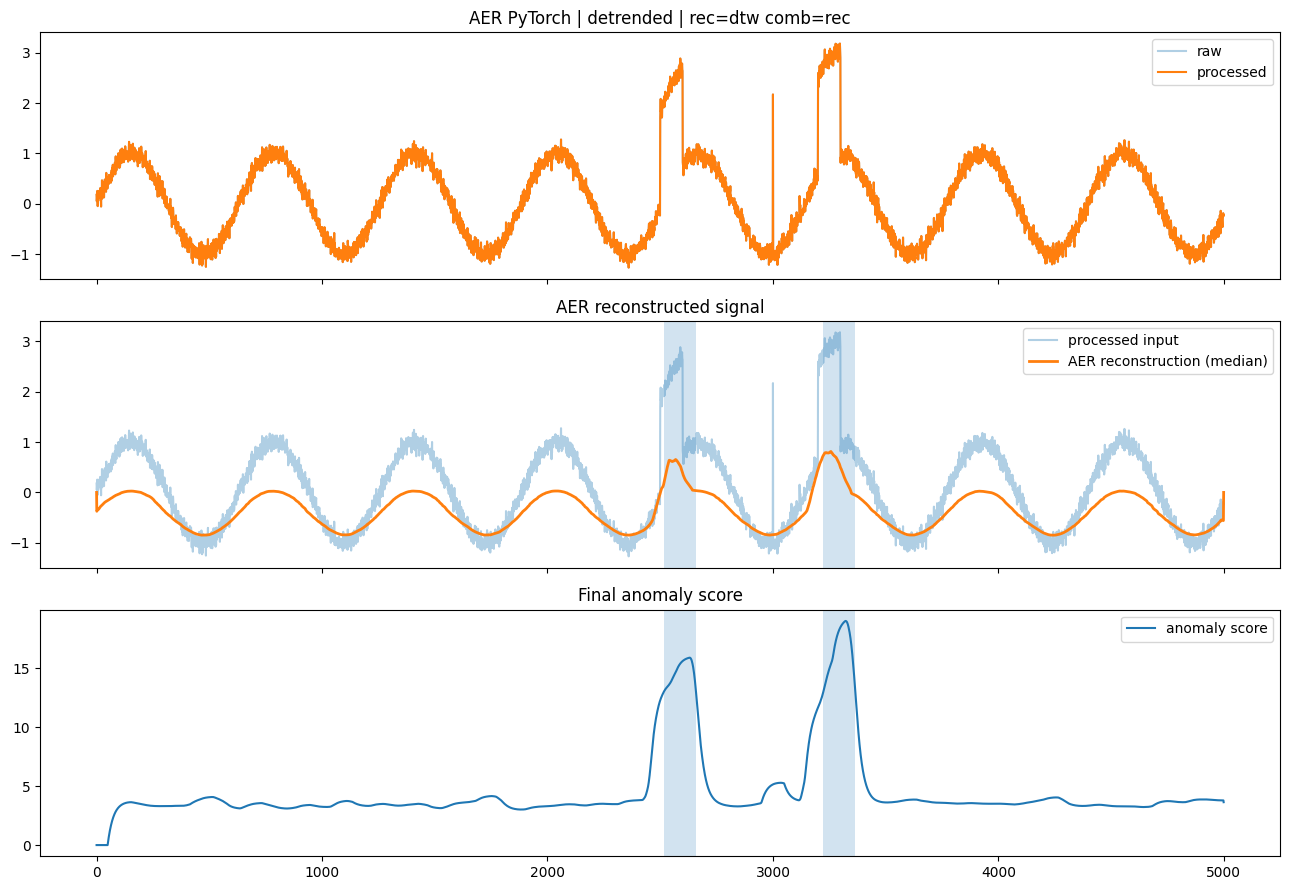

threshold: [13.00363369 13.00363369 13.00363369 ... 13.00363369 13.00363369
 13.00363369]
first intervals: [(2516, 2659, 14.773719462085253), (3224, 3366, 16.694580903009165)]


In [6]:
# 13) Example usage
np.random.seed(0)

T = 5000
x = np.sin(np.linspace(0, 50, T)) + 0.1 * np.random.randn(T)
x[2500:2600] += 2.0
x[3200:3300] += 2.0
x[3000] += 3            # injected anomaly
x[100] = np.nan              # missing value example

results = run_aer_pipeline_pytorch(
    x=x,
    n=100,
    units=30,
    reg_ratio=0.5,
    lr=1e-3,
    epochs=10,
    batch_size=64,
    do_impute=True,
    do_detrend=False,
    rec_error_type="dtw",     # "point" | "area" | "dtw"
    comb="rec",              # "pred" | "rec" | "sum" | "mult"
    #q=0.995,
    min_len=10,
    visualize=True,
    thresholding = "global_no_pruning"
)

print("threshold:", results["threshold"])
print("first intervals:", results["intervals"][:5])

Trying out the AER implementation with a synthetic time series which has a trend.

epoch 001/010 | loss 0.134173 | device cpu
epoch 002/010 | loss 0.044998 | device cpu
epoch 003/010 | loss 0.026773 | device cpu
epoch 004/010 | loss 0.020823 | device cpu
epoch 005/010 | loss 0.020136 | device cpu
epoch 006/010 | loss 0.016766 | device cpu
epoch 007/010 | loss 0.016625 | device cpu
epoch 008/010 | loss 0.013173 | device cpu
epoch 009/010 | loss 0.014510 | device cpu
epoch 010/010 | loss 0.011544 | device cpu


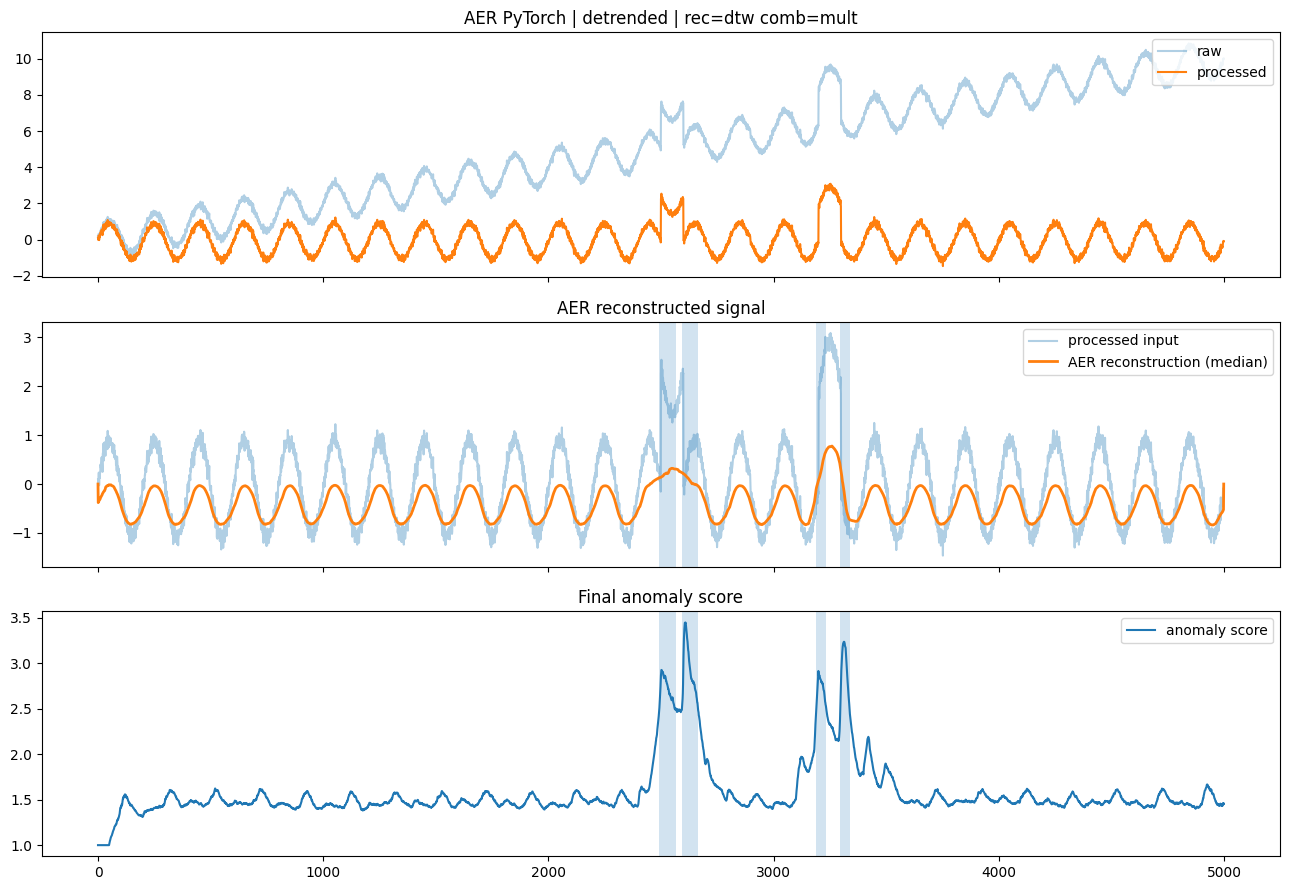

threshold curve (first 20): [2.49272538 2.49272538 2.49272538 2.49272538 2.49272538 2.49272538
 2.49272538 2.49272538 2.49272538 2.49272538 2.49272538 2.49272538
 2.49272538 2.49272538 2.49272538 2.49272538 2.49272538 2.49272538
 2.49272538 2.49272538]
detected intervals (first 5): [(2493, 2566, 2.714415437506031), (2592, 2665, 2.9342474290807785), (3190, 3235, 2.7313146029479203), (3297, 3338, 2.9692262813175714)]


In [7]:
import numpy as np

np.random.seed(0)

T = 5000
t = np.arange(T)

# Trend + seasonal + noise signal
trend = 0.002 * t
seasonal = np.sin(2 * np.pi * t / 200)
noise = 0.1 * np.random.randn(T)

x = trend + seasonal + noise

# Inject contextual anomalies
x[2500:2600] += 2.5
x[3200:3300] += 2.0

# Inject missing value (tests imputation)
x[100] = np.nan

# Run AER pipeline (latest version)
results = run_aer_pipeline_pytorch(
    x=x,
    n=100,
    units=30,
    reg_ratio=0.5,
    lr=1e-3,
    epochs=10,
    batch_size=64,
    do_impute=True,
    do_detrend=True,              # IMPORTANT: detrending enabled
    rec_error_type="dtw",         # contextual anomaly sensitivity
    comb="mult",                  # prediction × reconstruction
    min_len=10,
    m=int(0.01 * T),              # paper-correct masking
    thresholding="global_no_pruning",
    visualize=True
)

# Inspect results
print("threshold curve (first 20):", results["threshold"][:20])
print("detected intervals (first 5):", results["intervals"][:5])


The following code tests our AER implementation on the UCR data set, we take the first 10000 points of the time series and do anomaly detection. Note that the following code block is written for Google Collab compatibility. Make the necessary minimal modifications in the data set reading cells if you are running it locally.


In [9]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Mounted at /content/drive


In [10]:
!unzip /content/drive/MyDrive/UCR.zip -d /content/

Archive:  /content/drive/MyDrive/UCR.zip
   creating: /content/UCR/
  inflating: /content/UCR/051-DISTORTEDTkeepSecondMARS.csv  
  inflating: /content/UCR/228-mit14134longtermecg.csv  
  inflating: /content/UCR/105-NOISEgait3-train.csv  
  inflating: /content/UCR/204-CHARISfive.csv  
  inflating: /content/UCR/113-CIMIS44AirTemperature1.csv  
  inflating: /content/UCR/097-NOISEGP711MarkerLFM5z3-test.csv  
  inflating: /content/UCR/172-gaitHunt3-test.csv  
  inflating: /content/UCR/173-insectEPG1.csv  
  inflating: /content/UCR/105-NOISEgait3.csv  
  inflating: /content/UCR/240-taichidbS0715Master-test.csv  
  inflating: /content/UCR/231-mit14134longtermecg-test.csv  
  inflating: /content/UCR/022-DISTORTEDGP711MarkerLFM5z4-train.csv  
  inflating: /content/UCR/209-Fantasia-test.csv  
  inflating: /content/UCR/141-InternalBleeding5-train.csv  
  inflating: /content/UCR/131-GP711MarkerLFM5z5.csv  
  inflating: /content/UCR/200-tiltAPB4.csv  
  inflating: /content/UCR/082-DISTORTEDresperat

In [11]:
# Loading the time series
ucr_path="UCR/001-DISTORTED1sddb40.csv"

df_UCR = pd.read_csv(
    ucr_path,
    header=None,
    names=["value_UCR"]
)

# Ensure numeric type and drop invalid entries if any
df_UCR["value_UCR"] = pd.to_numeric(df_UCR["value_UCR"], errors="coerce")
df_UCR = df_UCR.dropna()

# Convert to numpy array
x_UCR = df_UCR["value_UCR"].to_numpy()
x_UCR=x_UCR[:10000]

# Basic info
print(f"UCR time series length: {len(x_UCR)}")
print(f"UCR value range: [{x_UCR.min():.2f}, {x_UCR.max():.2f}]")

UCR time series length: 10000
UCR value range: [-755.51, 836.23]


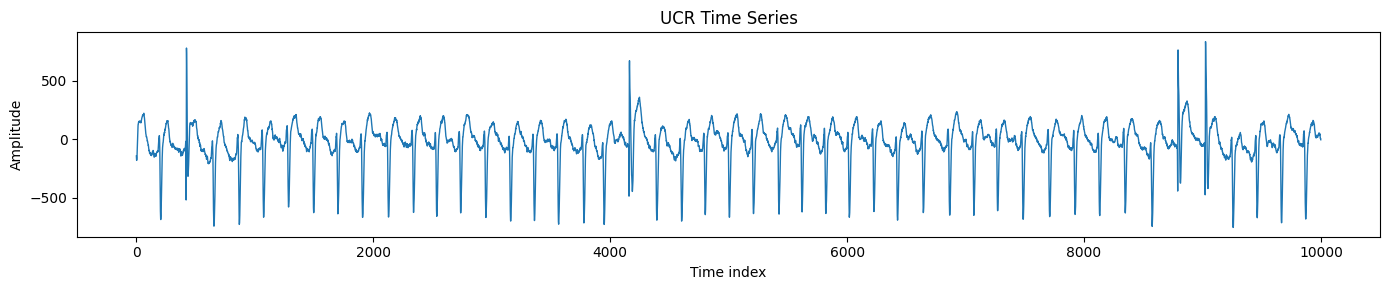

In [12]:
# Visualization of the UCR time series

plt.figure(figsize=(14, 3))
plt.plot(x_UCR, lw=1)
plt.title("UCR Time Series")
plt.xlabel("Time index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

Running the AER implementation:

epoch 001/015 | loss 0.032969 | device cpu
epoch 002/015 | loss 0.022086 | device cpu
epoch 003/015 | loss 0.011961 | device cpu
epoch 004/015 | loss 0.006991 | device cpu
epoch 005/015 | loss 0.005468 | device cpu
epoch 006/015 | loss 0.003871 | device cpu
epoch 007/015 | loss 0.003279 | device cpu
epoch 008/015 | loss 0.002891 | device cpu
epoch 009/015 | loss 0.002824 | device cpu
epoch 010/015 | loss 0.002475 | device cpu
epoch 011/015 | loss 0.002375 | device cpu
epoch 012/015 | loss 0.002382 | device cpu
epoch 013/015 | loss 0.002168 | device cpu
epoch 014/015 | loss 0.002059 | device cpu
epoch 015/015 | loss 0.001988 | device cpu


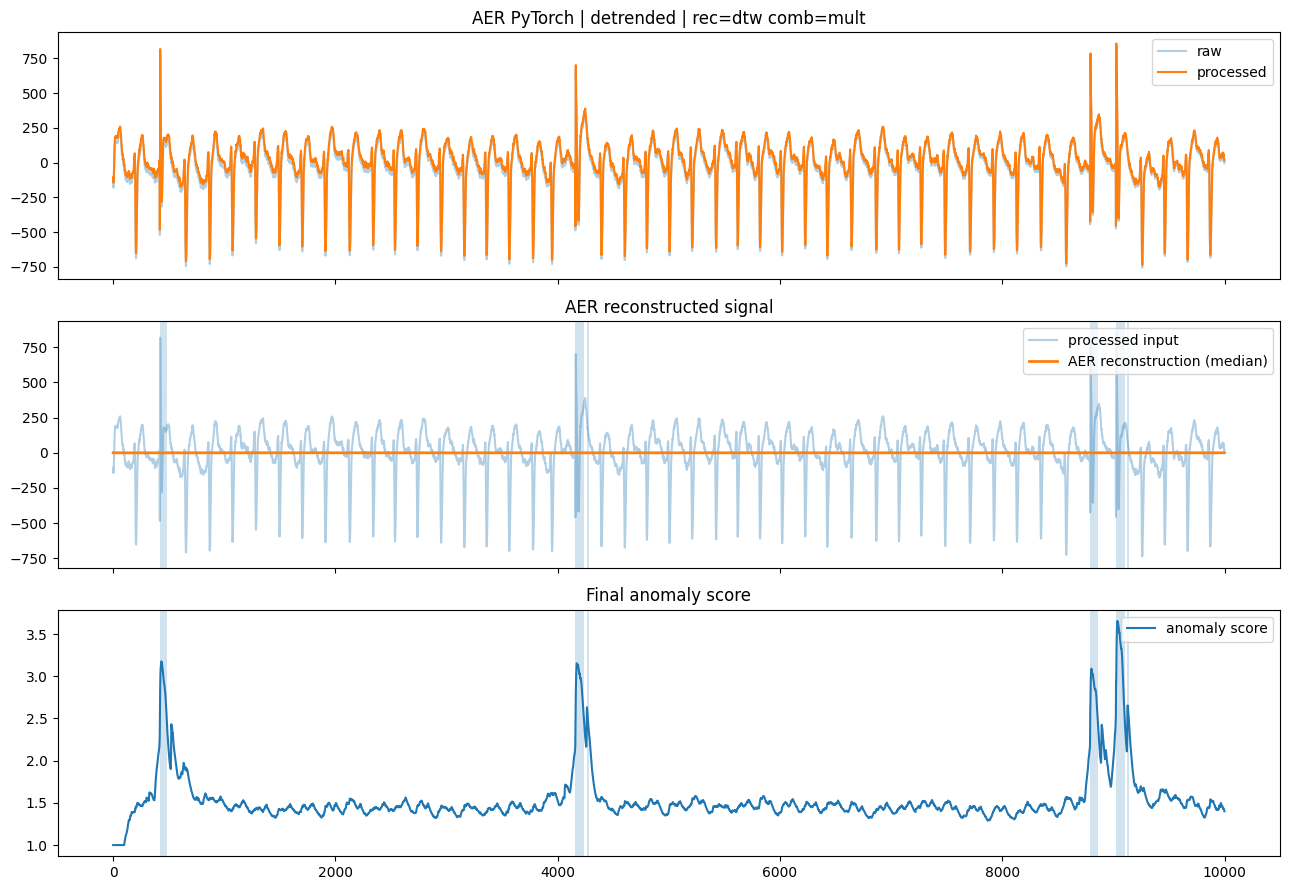

In [13]:
results = run_aer_pipeline_pytorch(
    x=x_UCR,
    n=100,
    units=30,
    reg_ratio=0.5,
    lr=1e-3,
    epochs=15,
    batch_size=64,
    do_impute=True,
    do_detrend=True,                # IMPORTANT for UCR
    rec_error_type="dtw",            # contextual anomalies
    comb="mult",
    m=int(0.01 * len(x_UCR)),            # paper default
    thresholding="global_no_pruning", # your chosen variant
    min_len=10,
    visualize=True
)

As we can see, the model is being able to correctly identify anomalies/patterns that strictly deviate from the norm.

---

In the AER implementation above, we are training the model and detecting the anomalies on the same set. In order to make it a bit more generalizable, we would want our AER implementation to train on the "Train set" and we should then be able to do the inference on other similar data sets or on the "Test set". This reduces training time and makes our trained models reusable for anomaly detection. We have made the necessary changes and modifications to our code above to ensure this extension. Although, the following code is functional, allowing models to be reusable, there seems to be a slight drop in performance primarily attributed to some changing parameters and altered dependecies that we have not been able to pin point thus far. However, the implementation is ready to be tested and used.

In [14]:
# ============================================================
# AER (Auto-Encoder with Bi-directional Regression) in PyTorch
#
# Includes:
#  1) Imputation (linear here in our implementation)
#  2) Optional detrending (least-squares line, linear for the instance)
#  3) Scaling (MinMax to [-1, 1]) + inverse available
#  4) Sliding windows (n+2)
#  5) BiLSTM encoder + BiLSTM decoder
#  6) Training loop (3-headed loss: reverse/regression/reconstruction/forward)
#  7) Regression score (bi-directional) with masking + EWMA
#  8) Reconstruction score (point / area / dtw) with masking + EWMA
#  9) Score combination (pred / rec / sum / mult)
# 10) Threshold + anomaly interval extraction (AD)
# 11) Optional visualization
#
# Dependencies: numpy, torch, matplotlib
# Works well on Python 3.10–3.12 (PyTorch-supported), CPU or GPU.
# ============================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Optional plotting
try:
    import matplotlib.pyplot as plt
    _HAS_PLT = True
except Exception:
    _HAS_PLT = False


# 1) Preprocessing: impute + detrend + scale

# impute
def impute_linear(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float).copy()
    n = len(x)
    mask = np.isnan(x)
    if not mask.any():
        return x

    idx = np.arange(n)
    good = ~mask

    # if all nan, fall back to zeros
    if good.sum() == 0:
        return np.zeros_like(x)

    # if nan at boundaries, np.interp fills using nearest good values
    x[mask] = np.interp(idx[mask], idx[good], x[good])
    return x


# detrend
def detrend_least_squares(x: np.ndarray) -> np.ndarray:
    """
    Fit x_t ≈ a t + b (least squares) and subtract fitted trend.
    """
    x = np.asarray(x, dtype=float)
    t = np.arange(len(x), dtype=float)
    t_mean = t.mean()
    x_mean = x.mean()
    denom = np.sum((t - t_mean) ** 2)
    if denom < 1e-12:
        return x - x_mean
    a = np.sum((t - t_mean) * (x - x_mean)) / denom
    b = x_mean - a * t_mean
    trend = a * t + b
    return x - trend

# scale
class MinMaxScaler1D:
    """
    Lightweight MinMax scaler for 1D arrays.
    Default target range: [-1, 1] to match common LSTM practice in AER pipeline.
    """
    def __init__(self, feature_range=(-1.0, 1.0), eps=1e-12):
        self.a, self.b = float(feature_range[0]), float(feature_range[1])
        self.eps = eps
        self.data_min_ = None
        self.data_max_ = None

    def fit(self, x: np.ndarray):
        x = np.asarray(x, dtype=float)
        self.data_min_ = float(np.min(x))
        self.data_max_ = float(np.max(x))
        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        x = np.asarray(x, dtype=float)
        mn, mx = self.data_min_, self.data_max_
        denom = (mx - mn) if (mx - mn) > self.eps else self.eps
        z = (x - mn) / denom
        return z * (self.b - self.a) + self.a

    def inverse_transform(self, z: np.ndarray) -> np.ndarray:
        z = np.asarray(z, dtype=float)
        mn, mx = self.data_min_, self.data_max_
        denom = (mx - mn) if (mx - mn) > self.eps else self.eps
        x = (z - self.a) / (self.b - self.a)  # back to [0,1]
        return x * denom + mn

# return the processed signals
def preprocess_signal(
    x: np.ndarray,
    do_impute: bool = True,
    do_detrend: bool = False,
    scale_range=(-1.0, 1.0),
    scaler: MinMaxScaler1D = None,
    fit_scaler: bool = True
):
    """
    Returns:
      x_raw, x_proc, x_scaled, scaler_used
    """
    x_raw = np.asarray(x, dtype=float).copy()
    x_proc = x_raw.copy()

    if do_impute:
        x_proc = impute_linear(x_proc)

    if do_detrend:
        x_proc = detrend_least_squares(x_proc)

    if scaler is None:
        scaler = MinMaxScaler1D(feature_range=scale_range)

    if fit_scaler:
        scaler.fit(x_proc)

    x_scaled = scaler.transform(x_proc)

    return x_raw, x_proc, x_scaled, scaler


# 2) Window construction: AER windows of length n+2

def make_aer_windows(x_scaled: np.ndarray, n: int):
    """
    Windows:
      w_i = [x_{i-1}, x_i, ..., x_{i+n-1}, x_{i+n}]  length n+2
    Returns:
      W: (N, n+2)
      idx: (N,) the start i of the reconstruction segment x_i..x_{i+n-1}
    """
    x_scaled = np.asarray(x_scaled, dtype=float)
    T = len(x_scaled)
    windows, indices = [], []
    for i in range(1, T - n):
        windows.append(x_scaled[i-1:i+n+1])
        indices.append(i)
    return np.asarray(windows, dtype=float), np.asarray(indices, dtype=int)


class AERWindowDataset(Dataset):
    """
    Produces:
      X  : (n, 1)            the internal segment (window[1:-1])
      ry : scalar            window[0]
      y  : (n,)              window[1:-1]
      fy : scalar            window[-1]
      i  : int               mapping index (start of recon segment)
    """
    def __init__(self, x_scaled: np.ndarray, n: int):
        W, idx = make_aer_windows(x_scaled, n)
        self.W = W
        self.idx = idx
        self.n = n

    def __len__(self):
        return self.W.shape[0]

    def __getitem__(self, k):
        w = self.W[k]
        i = int(self.idx[k])

        X = w[1:-1]                      # (n,)
        ry = w[0]                        # scalar
        y = w[1:-1]                      # (n,)
        fy = w[-1]                       # scalar

        # Return tensors
        X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)     # (n,1)
        ry_t = torch.tensor(ry, dtype=torch.float32)                 # ()
        y_t  = torch.tensor(y, dtype=torch.float32)                  # (n,)
        fy_t = torch.tensor(fy, dtype=torch.float32)                 # ()
        i_t  = torch.tensor(i, dtype=torch.long)

        return X_t, ry_t, y_t, fy_t, i_t


# 3) AER model in PyTorch: BiLSTM encoder + BiLSTM decoder

class AERBiLSTM(nn.Module):
    """
    Encoder: BiLSTM over length n -> latent vector of size 2*units
    Decoder: repeat latent over length (n+2), BiLSTM -> per-time output -> (n+2)
    Outputs:
      ry_hat: (B,)          output[0]
      y_hat : (B, n)        output[1:-1]
      fy_hat: (B,)          output[-1]
    """
    def __init__(self, n: int, units: int = 30):
        super().__init__()
        self.n = n
        self.units = units

        self.enc = nn.LSTM(
            input_size=1,
            hidden_size=units,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.dec = nn.LSTM(
            input_size=2*units,
            hidden_size=units,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Project BiLSTM decoder outputs (2*units) -> scalar value per time step
        self.proj = nn.Linear(2*units, 1)

    def forward(self, X):
        """
        X: (B, n, 1)
        returns ry_hat (B,), y_hat (B,n), fy_hat (B,)
        """
        B = X.size(0)

        # Encoder: take last hidden states of both directions -> (B, 2*units)
        _, (h_n, _) = self.enc(X)
        # h_n: (num_layers*directions=2, B, units)
        h_fwd = h_n[0]               # (B, units)
        h_bwd = h_n[1]               # (B, units)
        z = torch.cat([h_fwd, h_bwd], dim=1)  # (B, 2*units)

        # Repeat latent for decoder over length n+2
        L = self.n + 2
        z_rep = z.unsqueeze(1).repeat(1, L, 1)  # (B, n+2, 2*units)

        dec_out, _ = self.dec(z_rep)           # (B, n+2, 2*units)
        out = self.proj(dec_out).squeeze(-1)   # (B, n+2)

        ry_hat = out[:, 0]                     # (B,)
        y_hat  = out[:, 1:-1]                  # (B, n)
        fy_hat = out[:, -1]                    # (B,)

        return ry_hat, y_hat, fy_hat


# 4) Training loop

def train_aer(
    x_scaled: np.ndarray,
    n: int = 100,
    units: int = 30,
    reg_ratio: float = 0.5,
    lr: float = 1e-3,
    epochs: int = 30,
    batch_size: int = 64,
    device: str = None,
    verbose: bool = True
):
    """
    reg_ratio corresponds to gamma in the paper.
    loss = (gamma/2)*MSE(ry) + (1-gamma)*MSE(recon) + (gamma/2)*MSE(fy)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    ds = AERWindowDataset(x_scaled, n)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)

    model = AERBiLSTM(n=n, units=units).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    for ep in range(1, epochs + 1):
        model.train()
        total = 0.0
        num = 0

        for X, ry, y, fy, _ in dl:
            X = X.to(device)                  # (B,n,1)
            ry = ry.to(device)                # (B,)
            y  = y.to(device)                 # (B,n)
            fy = fy.to(device)                # (B,)

            opt.zero_grad()
            ry_hat, y_hat, fy_hat = model(X)

            loss_ry = mse(ry_hat, ry)
            loss_y  = mse(y_hat, y)
            loss_fy = mse(fy_hat, fy)

            loss = (reg_ratio/2.0) * loss_ry + (1.0 - reg_ratio) * loss_y + (reg_ratio/2.0) * loss_fy
            loss.backward()
            opt.step()

            total += float(loss.item()) * X.size(0)
            num += X.size(0)

        if verbose:
            print(f"epoch {ep:03d}/{epochs:03d} | loss {total / max(num,1):.6f} | device {device}")

    return model, device


# 5) Prediction on all windows (to build scores)

@torch.no_grad()
def predict_aer_windows(model: nn.Module, x_scaled: np.ndarray, n: int, device: str = None, batch_size: int = 256):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    ds = AERWindowDataset(x_scaled, n)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False)

    model.eval()

    ry_list, y_list, fy_list, idx_list = [], [], [], []

    for X, _, _, _, idx in dl:
        X = X.to(device)
        ry_hat, y_hat, fy_hat = model(X)

        ry_list.append(ry_hat.cpu().numpy())
        y_list.append(y_hat.cpu().numpy())
        fy_list.append(fy_hat.cpu().numpy())
        idx_list.append(idx.cpu().numpy())

    ry_hat = np.concatenate(ry_list, axis=0)        # (N,)
    y_hat  = np.concatenate(y_list, axis=0)         # (N,n)
    fy_hat = np.concatenate(fy_list, axis=0)        # (N,)
    idx    = np.concatenate(idx_list, axis=0)       # (N,)

    return ry_hat, y_hat, fy_hat, idx



# 6) Smoothing + masking

def ewma_windowed(scores: np.ndarray, window_frac: float = 0.1) -> np.ndarray:
    """
    EWMA with an effective window length ~ window_frac * T.
    We convert window length L to alpha via the common rule alpha = 2/(L+1).
    """
    s = np.asarray(scores, dtype=float)
    T = len(s)
    L = max(1, int(window_frac * T))
    alpha = 2.0 / (L + 1.0)

    out = np.empty_like(s)
    out[0] = s[0]
    for i in range(1, T):
        out[i] = alpha * s[i] + (1.0 - alpha) * out[i - 1]
    return out


def apply_mask(scores: np.ndarray, m: int, mode: str = "min") -> np.ndarray:
    s = np.asarray(scores, dtype=float).copy()
    if m <= 0:
        return s
    if m >= len(s):
        return s
    if mode == "zero":
        s[:m] = 0.0
    else:
        s[:m] = np.min(s[m:])
    return s


# Paper-faithful Bi-directional prediction anomaly scores (Eq. 1 + Eq. 6)

def regression_scores_paper(
    x_scaled: np.ndarray,
    ry_hat: np.ndarray,
    fy_hat: np.ndarray,
    idx: np.ndarray,
    n: int,
    smooth: bool = True,
    smoothing_window: float = 0.01,
    mask: bool = True,
    m: int = None
) -> np.ndarray:
    """
    Implements the paper’s bi-directional scoring:
      - forward scores at t = i+n  (i = idx)
      - reverse scores at t = i-1  (i = idx)
      - masking: forward first m -> 0 ; reverse first m -> min(reverse)
      - padding: forward prepend n zeros ; reverse append n zeros
      - combine: overlap -> average ; non-overlap -> max   (Eq. 6)
    """
    x_scaled = np.asarray(x_scaled, dtype=float)
    T = len(x_scaled)

    # α_p(t,f) stored into f_base at its true timestamp t
    f_base = np.zeros(T, dtype=float)
    f_count = np.zeros(T, dtype=int)

    for i, f in zip(idx, fy_hat):
        t = int(i + n)
        if 0 <= t < T:
            f_base[t] += abs(x_scaled[t] - f)
            f_count[t] += 1

    # average if multiple preds land on same t (still consistent with α_p definition)
    f_base = np.divide(f_base, np.maximum(f_count, 1))

    # α_p(t,r) stored into r_base at its true timestamp t
    r_base = np.zeros(T, dtype=float)
    r_count = np.zeros(T, dtype=int)

    for i, r in zip(idx, ry_hat):
        t = int(i - 1)
        if 0 <= t < T:
            r_base[t] += abs(x_scaled[t] - r)
            r_count[t] += 1

    r_base = np.divide(r_base, np.maximum(r_count, 1))

    # masking (paper: m defaults to 0.017T in their best setting; keep yours overrideable)
    if mask:
        if m is None:
            m = max(1, int(0.017 * T))
        # forward: first m set to 0
        f_base[:m] = 0.0
        # reverse: first m set to min(reverse) (computed from the rest)
        if m < T:
            r_min = float(np.min(r_base[m:]))
            r_base[:m] = r_min

    # padding to align per paper description
    f = np.concatenate([np.zeros(n, dtype=float), f_base])[:T]        # prepend n zeros
    r = np.concatenate([r_base, np.zeros(n, dtype=float)])[:T]        # append n zeros

    # combine with Eq. (6)
    scores = np.zeros(T, dtype=float)

    # overlap region in the paper is the middle; outside overlap use max
    # We implement exactly the three cases shown in Eq.(6)-style description:
    #   early: use r
    #   middle: average
    #   late: use f
    early_end = min(T, n + m)             # inclusive end (0-based)
    late_start = max(0, T - n)            # start of late region

    for t in range(T):
        if t < early_end:
            scores[t] = r[t]
        elif t >= late_start:
            scores[t] = f[t]
        else:
            scores[t] = 0.5 * (f[t] + r[t])

    if smooth:
        scores = ewma_windowed(scores, window_frac=smoothing_window)

    return scores



# 8) Reconstruction scores (point / area / dtw)

# for the discussion and usefullness of the 2 DTW implementations
# below, have a look at their implementations in the AER code block
# above (the first code block implementing AER)

def dtw_distance(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    n, m = len(a), len(b)
    D = np.full((n + 1, m + 1), np.inf, dtype=float)
    D[0, 0] = 0.0
    for i in range(1, n + 1):
        ai = a[i - 1]
        for j in range(1, m + 1):
            cost = abs(ai - b[j - 1])
            D[i, j] = cost + min(D[i - 1, j], D[i, j - 1], D[i - 1, j - 1])
    return float(D[n, m])


# def dtw_distance(a: np.ndarray, b: np.ndarray) -> float:
#     """
#     Paper-faithful DTW anomaly score:
#     returns (1/Q) * sum_{q=1}^Q c_q
#     where Q is the length of the optimal warping path.
#     """
#     a = np.asarray(a, dtype=float)
#     b = np.asarray(b, dtype=float)

#     n, m = len(a), len(b)

#     # DP tables: cumulative cost and path length
#     D = np.full((n + 1, m + 1), np.inf, dtype=float)
#     L = np.zeros((n + 1, m + 1), dtype=int)

#     D[0, 0] = 0.0
#     L[0, 0] = 0

#     for i in range(1, n + 1):
#         ai = a[i - 1]
#         for j in range(1, m + 1):
#             cost = abs(ai - b[j - 1])

#             # choose predecessor with minimal cumulative cost
#             choices = (
#                 D[i - 1, j],     # vertical
#                 D[i, j - 1],     # horizontal
#                 D[i - 1, j - 1]  # diagonal
#             )
#             k = int(np.argmin(choices))

#             if k == 0:
#                 prev_i, prev_j = i - 1, j
#             elif k == 1:
#                 prev_i, prev_j = i, j - 1
#             else:
#                 prev_i, prev_j = i - 1, j - 1

#             D[i, j] = cost + D[prev_i, prev_j]
#             L[i, j] = L[prev_i, prev_j] + 1

#     # Eq. (4): average cost along optimal warping path
#     return float(D[n, m] / max(L[n, m], 1))


def reconstruction_scores_paper(
    x_scaled: np.ndarray,
    y_hat: np.ndarray,
    idx: np.ndarray,
    n: int,
    rec_error_type: str = "dtw",    # "point" | "area" | "dtw"
    smooth: bool = True,
    smoothing_window: float = 0.1,
    mask: bool = True,
    m: int = None
):
    """
    Paper-faithful reconstruction anomaly score.

    Steps:
      1) Aggregate overlapping reconstructions via MEDIAN -> y[t]
      2) Compute reconstruction error:
         - point: |x_t - y_t|
         - area : local mean of |x - y|
         - dtw  : WINDOW-LEVEL DTW, assigned to window, aggregated by median
      3) Mask initial region
      4) EWMA smoothing
    """
    x_scaled = np.asarray(x_scaled, dtype=float)
    T = len(x_scaled)

    # 1) Median-aggregated reconstructed signal
    y = aggregate_reconstruction_median(y_hat, idx, T=T, n=n)

    # 2) Reconstruction error
    pd = np.abs(x_scaled - y)

    if rec_error_type == "point":
        scores = pd

    elif rec_error_type == "area":
        ell = 10
        scores = np.zeros(T, dtype=float)

        diff = x_scaled - y

        for i in range(T):
            a = max(0, i - ell)
            b = min(T - 1, i + ell)

            # trapezoidal integration over [a, b]
            area = np.trapz(diff[a:b+1])

            scores[i] = abs(area) / (2.0 * ell)

    elif rec_error_type == "dtw":
        # PAPER-CORRECT DTW:
        # one DTW per reconstruction WINDOW (i, i+n)
        # assigned to that window, overlaps aggregated by MEDIAN
        buckets = [[] for _ in range(T)]

        for k, i in enumerate(idx):
            i = int(i)
            a = i
            b = min(T, i + n)

            d = dtw_distance(x_scaled[a:b], y[a:b])

            for t in range(a, b):
                buckets[t].append(d)

        scores = np.zeros(T, dtype=float)
        for t in range(T):
            if buckets[t]:
                scores[t] = float(np.median(buckets[t]))
            else:
                scores[t] = 0.0

    else:
        raise ValueError('rec_error_type must be one of ["point","area","dtw"]')

    # 3) Masking (paper uses initial masking)
    if mask:
        if m is None:
            m = max(1, int(0.01 * T))
        if m < T:
            scores[:m] = float(np.min(scores[m:]))
        else:
            scores[:] = scores[0]

    # 4) Smoothing
    if smooth:
        scores = ewma_windowed(scores, window_frac=smoothing_window)

    return scores, y

# Our implementation which will help us plot the predicted signal
# We are using median here

# Paper-faithful reconstruction aggregation: y_i = median of overlapping reconstructions

def aggregate_reconstruction_median(
    y_hat: np.ndarray,
    idx: np.ndarray,
    T: int,
    n: int
) -> np.ndarray:
    """
    Build a single reconstructed signal y of length T.
    For each time t, collect all reconstructed values y_hat[k, j]
    such that idx[k] + j == t, and set y[t] = median(collection).
    This matches the paper’s described aggregation.
    """
    buckets = [[] for _ in range(T)]

    for k, i in enumerate(idx):
        i = int(i)
        for j in range(n):
            t = i + j
            if 0 <= t < T:
                buckets[t].append(float(y_hat[k, j]))

    y = np.zeros(T, dtype=float)
    for t in range(T):
        if buckets[t]:
            y[t] = float(np.median(buckets[t]))
        else:
            y[t] = 0.0  # uncovered edges

    return y


# 9) Score combination (pred / rec / sum / mult)

def minmax_to_range(x: np.ndarray, lo: float, hi: float, eps: float = 1e-12) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    mn, mx = float(np.min(x)), float(np.max(x))
    denom = (mx - mn) if (mx - mn) > eps else eps
    z = (x - mn) / denom
    return z * (hi - lo) + lo

def combine_scores(
    reg: np.ndarray,
    rec: np.ndarray,
    comb: str = "mult",
    beta: float = 0.5
) -> np.ndarray:
    """
    comb:
      "pred": use reg only
      "rec":  use rec only
      "sum":  minmax to [0,1], then (1-beta)*rec + beta*reg
      "mult": minmax to [1,2], then reg * rec
    """
    reg = np.asarray(reg, dtype=float)
    rec = np.asarray(rec, dtype=float)

    if comb == "pred":
        return reg

    if comb == "rec":
        return rec

    if comb == "sum":
        r1 = minmax_to_range(reg, 0.0, 1.0)
        r2 = minmax_to_range(rec, 0.0, 1.0)
        return (1.0 - beta) * r2 + beta * r1

    if comb == "mult":
        r1 = minmax_to_range(reg, 1.0, 2.0)
        r2 = minmax_to_range(rec, 1.0, 2.0)
        return beta * r1 * r2

    raise ValueError('comb must be one of ["pred","rec","sum","mult"]')


# 10) Thresholding + anomaly intervals


# Paper-faithful thresholding: local adaptive thresholding + pruning

def local_adaptive_thresholding_paper(
    scores: np.ndarray,
    window_frac: float = 1/3,
    step_frac: float = 1/30,
    z: float = 4.0,
    max_len_frac: float = 1.0,
    theta: float = 0.13,
    min_len: int = 5
):
    """
    A simple implementation of the “non-parametric dynamic thresholding” described in the paper:
      - sliding window: compute mean + z*std per window
      - mark points above local threshold
      - merge consecutive points into intervals
      - pruning based on percentage decrease rule (theta)
    """
    s = np.asarray(scores, dtype=float)
    T = len(s)

    W = max(10, int(window_frac * T))
    step = max(1, int(step_frac * T))
    max_len = max(min_len, int(max_len_frac * T))

    # local thresholds (take max over overlaps for conservatism)
    thr = np.full(T, -np.inf, dtype=float)
    for start in range(0, T, step):
        end = min(T, start + W)
        w = s[start:end]
        mu = float(np.mean(w))
        sd = float(np.std(w))
        local = mu + z * sd
        # thr[start:end] = local
        thr[start:end] = np.maximum(thr[start:end], local)

        if end == T:
            break

    flags = s > thr

    # build raw intervals
    intervals = []
    i = 0
    while i < T:
        if not flags[i]:
            i += 1
            continue
        j = i
        while j < T and flags[j]:
            j += 1
        if j - i >= min_len:
            intervals.append((i, j))
        i = j

    # merge close intervals if needed (optional; keep conservative)
    merged = []
    for (a, b) in intervals:
        if not merged:
            merged.append([a, b])
        else:
            if a <= merged[-1][1]:
                merged[-1][1] = max(merged[-1][1], b)
            else:
                merged.append([a, b])
    intervals = [(a, b) for a, b in merged]

    # enforce max length
    trimmed = []
    for (a, b) in intervals:
        if b - a > max_len:
            # split into chunks
            k = a
            while k < b:
                kk = min(b, k + max_len)
                if kk - k >= min_len:
                    trimmed.append((k, kk))
                k = kk
        else:
            trimmed.append((a, b))
    intervals = trimmed

    # pruning by “percentage decrease” heuristic:
    # sort by max score in interval; keep until the next drop is <= theta
    if not intervals:
        return thr, []

    interval_peaks = [float(np.max(s[a:b])) for (a, b) in intervals]
    order = np.argsort(interval_peaks)[::-1]
    intervals_sorted = [intervals[k] for k in order]
    peaks_sorted = [interval_peaks[k] for k in order]

    keep = []
    for k in range(len(peaks_sorted)):
        keep.append(intervals_sorted[k])
        if k + 1 < len(peaks_sorted):
            if peaks_sorted[k] <= 0:
                continue
            drop = (peaks_sorted[k] - peaks_sorted[k + 1]) / peaks_sorted[k]
            if drop <= theta:
                # stop: remaining are reclassified as normal
                break

    # return intervals with mean score for plotting consistency
    out = [(a, b, float(np.mean(s[a:b]))) for (a, b) in keep]
    return thr, out

# Refer to the first AER code block right at the top for reference into the 2
# local_adaptive_thresholding_paper implementations that we have done and how to use them

# def local_adaptive_thresholding_paper(
#     scores: np.ndarray,
#     window_frac: float = 1/3,
#     step_frac: float = 1/30,
#     z: float = 4.0,
#     theta: float = 0.13
# ):
#     """
#     Paper-minimal implementation of the locally adaptive thresholding
#     described in the AER paper (Hundman et al.).

#     Returns:
#       thr : adaptive threshold per time index
#       out : list of (start, end, mean_score) anomalous intervals
#     """
#     s = np.asarray(scores, dtype=float)
#     T = len(s)

#     W = int(window_frac * T)
#     step = int(step_frac * T)

#
#     # 1) Sliding-window adaptive thresholds
#
#     thr = np.full(T, -np.inf, dtype=float)

#     for start in range(0, T - W + 1, step):
#         end = start + W
#         w = s[start:end]

#         mu = float(np.mean(w))
#         sd = float(np.std(w))
#         local_thr = mu + z * sd

#         # assign threshold for this window
#         thr[start:end] = np.maximum(thr[start:end], local_thr)

#
#     # 2) Flag anomalous points
#
#     flags = s > thr

#
#     # 3) Build anomalous intervals
#
#     intervals = []
#     i = 0
#     while i < T:
#         if not flags[i]:
#             i += 1
#             continue
#         j = i
#         while j < T and flags[j]:
#             j += 1
#         intervals.append((i, j))
#         i = j

#     if not intervals:
#         return thr, []

#
#     # 4) Pruning via percentage decrease rule
#
#     peaks = np.array([np.max(s[a:b]) for (a, b) in intervals])
#     order = np.argsort(peaks)[::-1]

#     intervals_sorted = [intervals[k] for k in order]
#     peaks_sorted = peaks[order]

#     keep = []
#     for k in range(len(peaks_sorted)):
#         keep.append(intervals_sorted[k])

#         if k + 1 < len(peaks_sorted):
#             drop = (peaks_sorted[k] - peaks_sorted[k + 1]) / peaks_sorted[k]
#             if drop <= theta:
#                 break

#
#     # 5) Output format (for plotting / consistency)

#     out = [(a, b, float(np.mean(s[a:b]))) for (a, b) in keep]

#     return thr, out


# local thresholding without paper-described pruning
def local_adaptive_thresholding_no_pruning(
    scores: np.ndarray,
    window_frac: float = 1/3,
    step_frac: float = 1/30,
    z: float = 4.0,
    max_len_frac: float = 1.0,
    min_len: int = 5
):
    """
    Non-parametric dynamic thresholding (paper-style), WITHOUT pruning:
      - sliding window: compute mean + z*std per window
      - take max threshold over overlapping windows
      - mark points above threshold
      - merge consecutive anomalous points into intervals
      - enforce minimum and maximum interval length
      - NO percentage-decrease pruning
    """
    s = np.asarray(scores, dtype=float)
    T = len(s)

    W = max(10, int(window_frac * T))
    step = max(1, int(step_frac * T))
    max_len = max(min_len, int(max_len_frac * T))

    # Local thresholds (max over overlaps, unchanged)
    thr = np.full(T, -np.inf, dtype=float)
    for start in range(0, T, step):
        end = min(T, start + W)
        w = s[start:end]

        mu = float(np.mean(w))
        sd = float(np.std(w))
        local = mu + z * sd

        thr[start:end] = np.maximum(thr[start:end], local)

        if end == T:
            break

    flags = s > thr

    # Build raw intervals
    intervals = []
    i = 0
    while i < T:
        if not flags[i]:
            i += 1
            continue
        j = i
        while j < T and flags[j]:
            j += 1
        if j - i >= min_len:
            intervals.append((i, j))
        i = j

    # Merge overlapping / adjacent intervals
    merged = []
    for (a, b) in intervals:
        if not merged:
            merged.append([a, b])
        else:
            if a <= merged[-1][1]:
                merged[-1][1] = max(merged[-1][1], b)
            else:
                merged.append([a, b])
    intervals = [(a, b) for a, b in merged]

    # Enforce maximum interval length
    trimmed = []
    for (a, b) in intervals:
        if b - a > max_len:
            k = a
            while k < b:
                kk = min(b, k + max_len)
                if kk - k >= min_len:
                    trimmed.append((k, kk))
                k = kk
        else:
            trimmed.append((a, b))
    intervals = trimmed

    # NO PRUNING — return all detected intervals
    out = [(a, b, float(np.mean(s[a:b]))) for (a, b) in intervals]
    return thr, out


# Global thresholding with pruning
def global_thresholding_with_pruning(
    scores: np.ndarray,
    z: float = 4.0,
    max_len_frac: float = 1.0,
    theta: float = 0.13,
    min_len: int = 5
):
    """
    Paper-style post-processing with a GLOBAL threshold:
      - threshold = median(scores) + z * std(scores)
      - all remaining steps identical to the paper
    """
    s = np.asarray(scores, dtype=float)
    T = len(s)

    max_len = max(min_len, int(max_len_frac * T))

    # GLOBAL threshold (ONLY change compared to local version)
    mu = float(np.median(s))        # changed from mean
    sd = float(np.std(s))           # standard deviation as usual
    thr = np.full(T, mu + z * sd)

    flags = s > thr

    # build raw intervals
    intervals = []
    i = 0
    while i < T:
        if not flags[i]:
            i += 1
            continue
        j = i
        while j < T and flags[j]:
            j += 1
        if j - i >= min_len:
            intervals.append((i, j))
        i = j

    # merge overlapping intervals
    merged = []
    for (a, b) in intervals:
        if not merged:
            merged.append([a, b])
        else:
            if a <= merged[-1][1]:
                merged[-1][1] = max(merged[-1][1], b)
            else:
                merged.append([a, b])
    intervals = [(a, b) for a, b in merged]

    # enforce max length
    trimmed = []
    for (a, b) in intervals:
        if b - a > max_len:
            k = a
            while k < b:
                kk = min(b, k + max_len)
                if kk - k >= min_len:
                    trimmed.append((k, kk))
                k = kk
        else:
            trimmed.append((a, b))
    intervals = trimmed

    # pruning by percentage decrease rule (theta)
    if not intervals:
        return thr, []

    interval_peaks = [float(np.max(s[a:b])) for (a, b) in intervals]
    order = np.argsort(interval_peaks)[::-1]
    intervals_sorted = [intervals[k] for k in order]
    peaks_sorted = [interval_peaks[k] for k in order]

    keep = []
    for k in range(len(peaks_sorted)):
        keep.append(intervals_sorted[k])
        if k + 1 < len(peaks_sorted):
            if peaks_sorted[k] <= 0:
                continue
            drop = (peaks_sorted[k] - peaks_sorted[k + 1]) / peaks_sorted[k]
            if drop <= theta:
                break

    out = [(a, b, float(np.mean(s[a:b]))) for (a, b) in keep]
    return thr, out

# global thresholding no pruning
def global_thresholding_no_pruning(
    scores: np.ndarray,
    z: float = 4.0,
    max_len_frac: float = 1.0,
    min_len: int = 5
):
    """
    Global thresholding with:
      - threshold = median(scores) + z * std(scores)
      - NO pruning / percentage-decrease rule
      - interval construction exactly as in the paper otherwise
    """
    s = np.asarray(scores, dtype=float)
    T = len(s)

    max_len = max(min_len, int(max_len_frac * T))

    # Global threshold
    mu = float(np.median(s))
    sd = float(np.std(s))
    thr = np.full(T, mu + z * sd, dtype=float)

    flags = s > thr

    # Build raw intervals
    intervals = []
    i = 0
    while i < T:
        if not flags[i]:
            i += 1
            continue
        j = i
        while j < T and flags[j]:
            j += 1
        if j - i >= min_len:
            intervals.append((i, j))
        i = j

    # Merge overlapping / adjacent intervals
    merged = []
    for (a, b) in intervals:
        if not merged:
            merged.append([a, b])
        else:
            if a <= merged[-1][1]:
                merged[-1][1] = max(merged[-1][1], b)
            else:
                merged.append([a, b])
    intervals = [(a, b) for a, b in merged]

    # Enforce maximum interval length
    trimmed = []
    for (a, b) in intervals:
        if b - a > max_len:
            k = a
            while k < b:
                kk = min(b, k + max_len)
                if kk - k >= min_len:
                    trimmed.append((k, kk))
                k = kk
        else:
            trimmed.append((a, b))
    intervals = trimmed

    # Return intervals (no pruning)
    out = [(a, b, float(np.mean(s[a:b]))) for (a, b) in intervals]
    return thr, out


def plot_results(
    x_raw: np.ndarray,
    x_proc: np.ndarray,
    y_recon_signal: np.ndarray,
    scores: np.ndarray,
    intervals,
    title: str = "AER (PyTorch)"
):
    """
    Plot:
      1) Raw vs processed signal
      2) Paper-faithful AER reconstructed signal (median-aggregated)
      3) Final anomaly score with detected intervals

    IMPORTANT:
    - y_recon_signal MUST already be aggregated using MEDIAN over overlaps
    - No reconstruction aggregation is performed here
    """

    if not _HAS_PLT:
        print("matplotlib not available; skipping plot.")
        return

    x_raw = np.asarray(x_raw, dtype=float)
    x_proc = np.asarray(x_proc, dtype=float)
    y_recon_signal = np.asarray(y_recon_signal, dtype=float)
    scores = np.asarray(scores, dtype=float)

    T = len(x_raw)
    t = np.arange(T)

    fig, ax = plt.subplots(3, 1, figsize=(13, 9), sharex=True)

    # 1) Raw vs processed signal
    ax[0].plot(t, x_raw, alpha=0.35, label="raw")
    ax[0].plot(t, x_proc, linewidth=1.5, label="processed")
    ax[0].set_title(title)
    ax[0].legend(loc="upper right")

    # 2) AER reconstructed signal
    ax[1].plot(t, x_proc, alpha=0.35, label="processed input")
    ax[1].plot(
        t,
        y_recon_signal,
        linewidth=2.0,
        label="AER reconstruction (median)"
    )

    for (a, b, _) in intervals:
        ax[1].axvspan(a, b, alpha=0.2)

    ax[1].legend(loc="upper right")
    ax[1].set_title("AER reconstructed signal")

    # 3) Final anomaly score
    ax[2].plot(t, scores, label="anomaly score")

    for (a, b, _) in intervals:
        ax[2].axvspan(a, b, alpha=0.2)

    ax[2].legend(loc="upper right")
    ax[2].set_title("Final anomaly score")

    plt.tight_layout()
    plt.show()




# 12) Full A→Z pipeline wrapper

def run_aer_pipeline_pytorch(
    x: np.ndarray,
    model=None,
    scaler=None,
    fit: bool = True,
    n: int = 100,
    units: int = 30,
    reg_ratio: float = 0.5,
    lr: float = 1e-3,
    epochs: int = 30,
    batch_size: int = 64,
    do_impute: bool = True,
    do_detrend: bool = False,
    m: int = None,
    # mask_mode: str = "min",
    rec_error_type: str = "dtw",      # "point" | "area" | "dtw"
    comb: str = "mult",              # "pred" | "rec" | "sum" | "mult"
    beta: float = 0.5,
    min_len: int = 5,
    device: str = None,
    visualize: bool = True,
    thresholding: str = "local_no_pruning"
  ):
    # Step 1–3: preprocess
    x_raw, x_proc, x_scaled, scaler_used = preprocess_signal(
    x,
    do_impute=do_impute,
    do_detrend=do_detrend,
    scale_range=(-1.0, 1.0),
    scaler=scaler,
    fit_scaler=fit
    )

    if fit:
        model, device_used = train_aer(
            x_scaled=x_scaled,
            n=n,
            units=units,
            reg_ratio=reg_ratio,
            lr=lr,
            epochs=epochs,
            batch_size=batch_size,
            device=device,
            verbose=True
        )
    else:
        if model is None:
            raise ValueError("Model must be provided when fit=False")
        device_used = device or next(model.parameters()).device


    # Step 5: predict windows
    ry_hat, y_hat, fy_hat, idx = predict_aer_windows(
        model=model,
        x_scaled=x_scaled,
        n=n,
        device=device_used,
        batch_size=max(128, batch_size)
    )

    # Step 6: regression score
    reg = regression_scores_paper(
        x_scaled=x_scaled,
        ry_hat=ry_hat,
        fy_hat=fy_hat,
        idx=idx,
        n=n,
        m=m
    )


    # Step 7: reconstruction score
    rec, y_recon_signal = reconstruction_scores_paper(
        x_scaled=x_scaled,
        y_hat=y_hat,
        idx=idx,
        n=n,
        rec_error_type=rec_error_type,
        m=m
    )



    # Step 8: combine
    scores = combine_scores(reg, rec, comb=comb, beta=beta)

    # Step 9: threshold + intervals
    # ------------------------------------------------------------
    if thresholding == "local_pruning":
        thr_curve, intervals = local_adaptive_thresholding_paper(
            scores,
            window_frac=1/3,
            step_frac=1/30,
            z=4.0,
            theta=0.13,
            min_len=min_len
        )

    elif thresholding == "local_no_pruning":
        thr_curve, intervals = local_adaptive_thresholding_no_pruning(
            scores,
            window_frac=1/3,
            step_frac=1/30,
            z=3.0,
            min_len=min_len
        )

    elif thresholding == "global_pruning":
        thr_curve, intervals = global_thresholding_with_pruning(
            scores,
            z=3.0,
            theta=0.13,
            min_len=min_len
        )

    elif thresholding == "global_no_pruning":
        thr_curve, intervals = global_thresholding_no_pruning(
            scores,
            z=3.0,
            min_len=min_len
        )

    else:
        raise ValueError(
            "thresholding must be one of: "
            "'local_pruning', 'local_no_pruning', "
            "'global_pruning', 'global_no_pruning'"
        )



    # Step 10: visualize
    if visualize:
        plot_results(
            x_raw=x_raw,
            x_proc=x_proc,
            y_recon_signal=y_recon_signal,
            scores=scores,
            intervals=intervals,
            title=f"AER PyTorch | detrended | rec={rec_error_type} comb={comb}"
    )


    return {
        "model": model,
        "device": device_used,
        "scaler": scaler_used,
        "x_raw": x_raw,
        "x_processed": x_proc,
        "x_scaled": x_scaled,
        "ry_hat": ry_hat,
        "y_hat": y_hat,
        "fy_hat": fy_hat,
        "idx": idx,
        "reg_scores": reg,
        "rec_scores": rec,
        "combined_scores": scores,
        "threshold": thr_curve,
        "intervals": intervals
    }


epoch 001/010 | loss 0.093536 | device cpu
epoch 002/010 | loss 0.022189 | device cpu
epoch 003/010 | loss 0.013068 | device cpu
epoch 004/010 | loss 0.011327 | device cpu
epoch 005/010 | loss 0.009572 | device cpu
epoch 006/010 | loss 0.008838 | device cpu
epoch 007/010 | loss 0.010458 | device cpu
epoch 008/010 | loss 0.008502 | device cpu
epoch 009/010 | loss 0.007733 | device cpu
epoch 010/010 | loss 0.007575 | device cpu


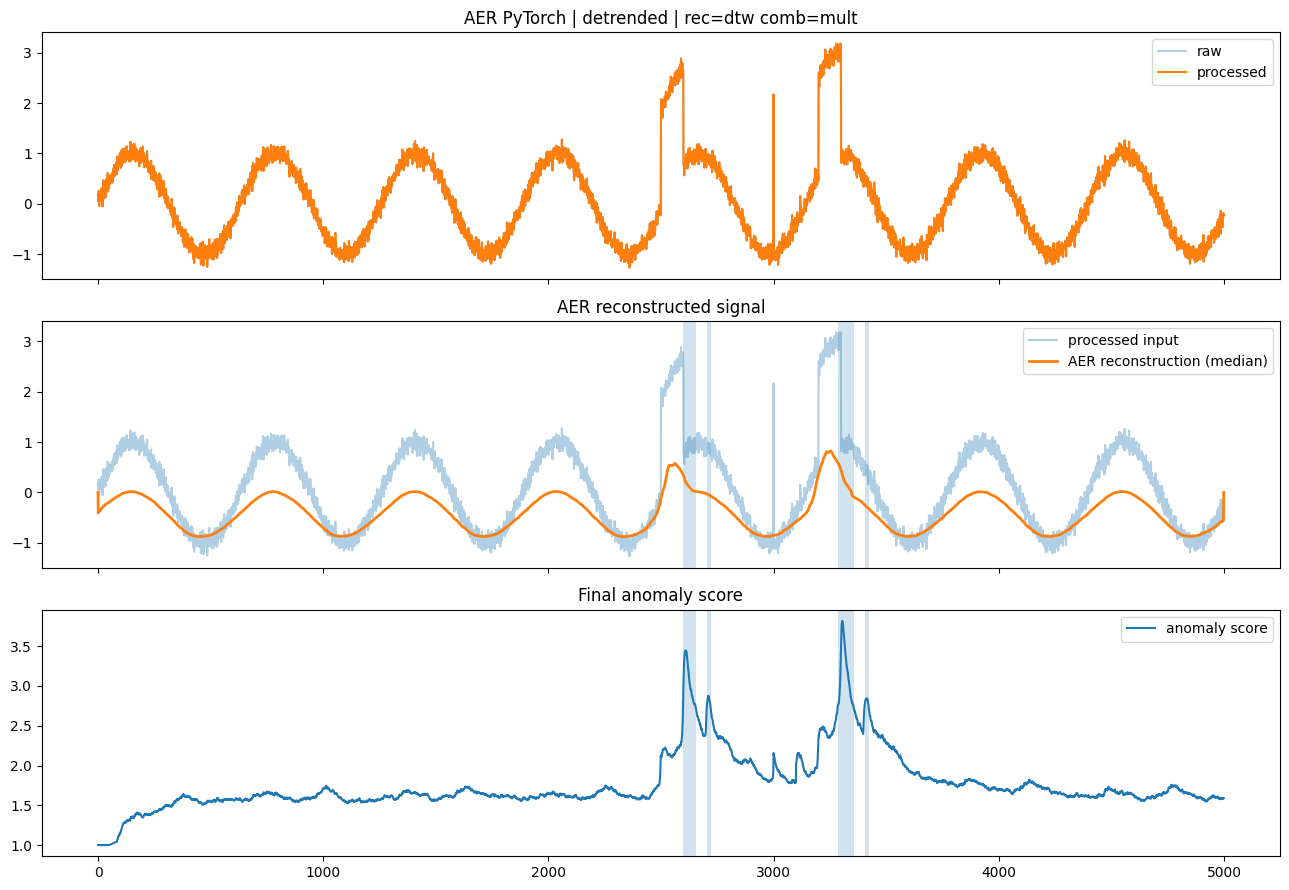

TRAIN thresholds: [2.74449111 2.74449111 2.74449111 2.74449111 2.74449111]
TRAIN intervals: [(2599, 2654, 3.080674443950549), (2704, 2720, 2.8251188892811276), (3285, 3356, 3.17928095157937), (3405, 3422, 2.8161343351962884)]


In [15]:
# Example usage: train once, reuse model
np.random.seed(0)

# (A) TRAIN + INFER on reference time series
T = 5000
x_train = np.sin(np.linspace(0, 50, T)) + 0.1 * np.random.randn(T)

# inject anomalies
x_train[2500:2600] += 2.0
x_train[3200:3300] += 2.0
x_train[3000] += 3.0
x_train[100] = np.nan

results_train = run_aer_pipeline_pytorch(
    x=x_train,
    fit=True,                  # <-- train here
    n=100,
    units=30,
    reg_ratio=0.5,
    lr=1e-3,
    epochs=10,
    batch_size=64,
    do_impute=True,
    do_detrend=False,
    rec_error_type="dtw",
    comb="mult",
    beta=1.0,
    min_len=10,
    visualize=True,
    thresholding="global_no_pruning"
)

print("TRAIN thresholds:", results_train["threshold"][:5])
print("TRAIN intervals:", results_train["intervals"][:5])


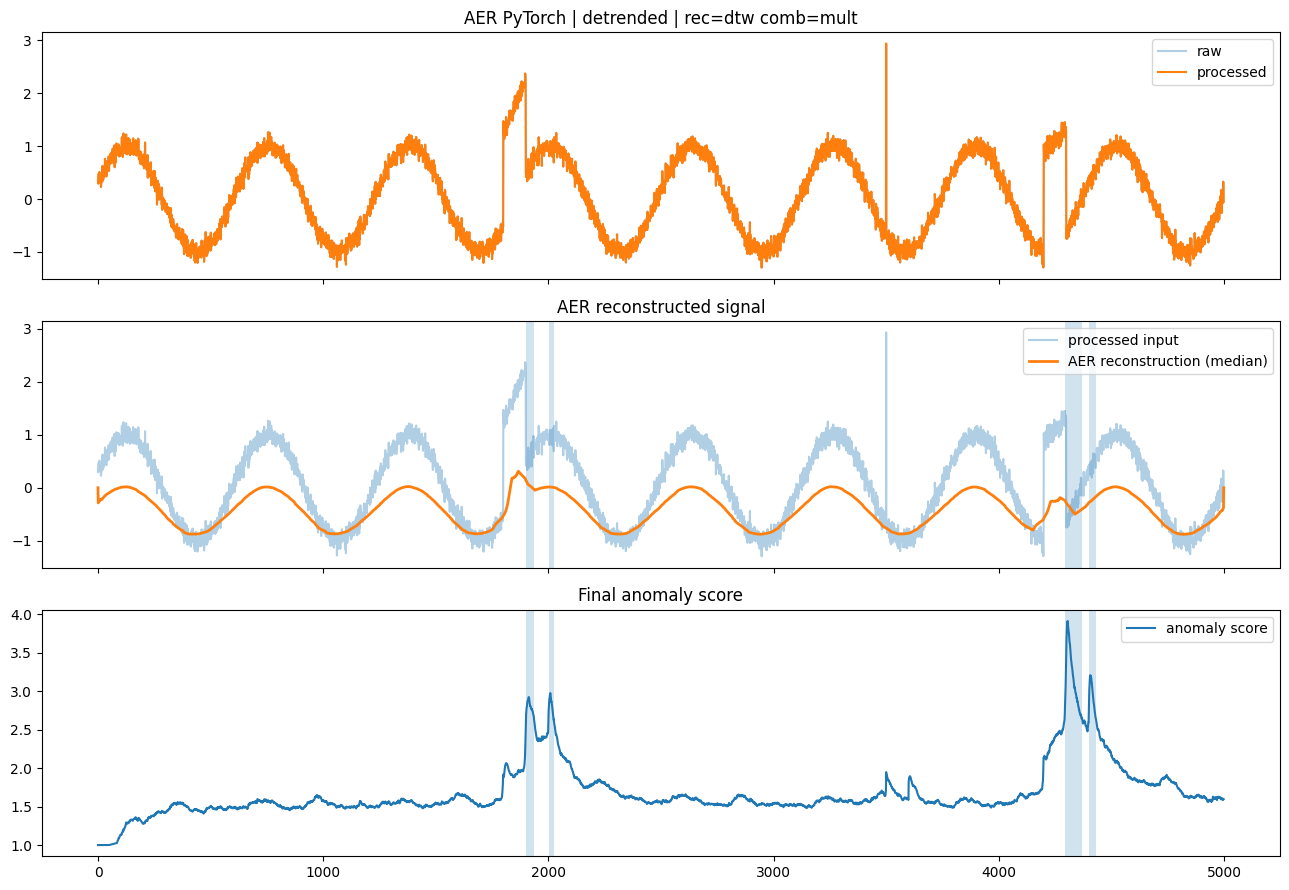

TEST thresholds: [2.64030661 2.64030661 2.64030661 2.64030661 2.64030661]
TEST intervals: [(1901, 1937, 2.7978711145341286), (2001, 2023, 2.8426654260893645), (4293, 4371, 3.161773428802116), (4400, 4432, 2.956034189067167)]


In [16]:
# (B) GENERATE A SIMILAR BUT NEW TIME SERIES

np.random.seed(42)

x_test = (
    np.sin(np.linspace(0, 50, T) + 0.3)   # phase shift
    + 0.1 * np.random.randn(T)
)

# inject different anomalies
x_test[1800:1900] += 1.8
x_test[3500] += 3.5
x_test[4200:4300] += 2.0

# (C) INFER ONLY using trained model + scaler
results_test = run_aer_pipeline_pytorch(
    x=x_test,
    fit=False,                            # <-- NO training
    model=results_train["model"],         # reuse trained AER
    scaler=results_train["scaler"],       # reuse scaler
    n=100,
    units=30,                             # must match training
    reg_ratio=0.5,
    batch_size=128,
    do_impute=True,
    do_detrend=False,
    rec_error_type="dtw",
    comb="mult",
    beta=1.0,
    min_len=10,
    visualize=True,
    thresholding="global_no_pruning"
)

print("TEST thresholds:", results_test["threshold"][:5])
print("TEST intervals:", results_test["intervals"][:5])


epoch 001/015 | loss 0.035409 | device cpu
epoch 002/015 | loss 0.021078 | device cpu
epoch 003/015 | loss 0.011032 | device cpu
epoch 004/015 | loss 0.006216 | device cpu
epoch 005/015 | loss 0.004368 | device cpu
epoch 006/015 | loss 0.003679 | device cpu
epoch 007/015 | loss 0.003273 | device cpu
epoch 008/015 | loss 0.003082 | device cpu
epoch 009/015 | loss 0.003007 | device cpu
epoch 010/015 | loss 0.002597 | device cpu
epoch 011/015 | loss 0.002507 | device cpu
epoch 012/015 | loss 0.002371 | device cpu
epoch 013/015 | loss 0.002320 | device cpu
epoch 014/015 | loss 0.002468 | device cpu
epoch 015/015 | loss 0.002083 | device cpu


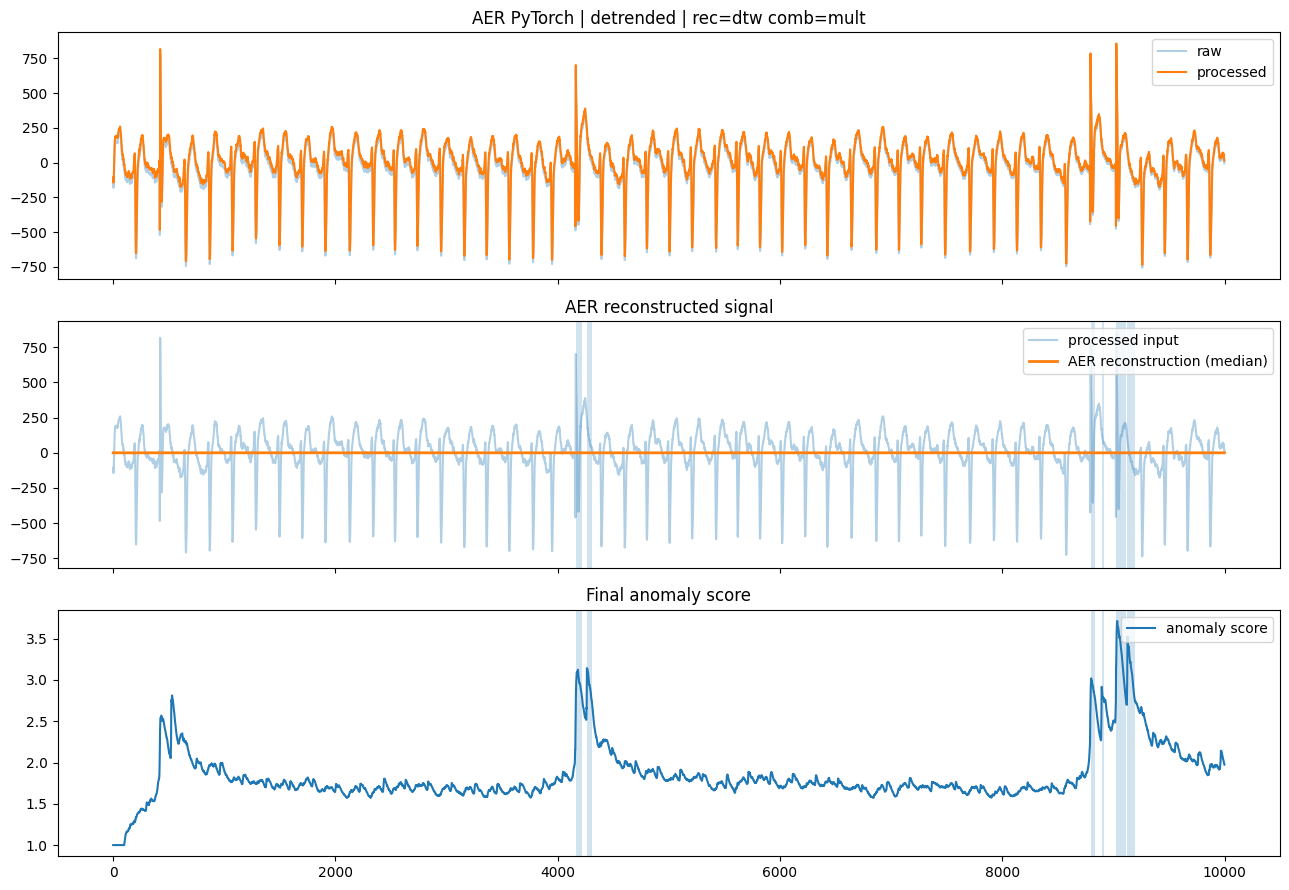

In [17]:
results = run_aer_pipeline_pytorch(
    x=x_UCR,
    fit=True,                         # <-- NEW (explicit)
    n=100,
    units=30,
    reg_ratio=0.5,
    lr=1e-3,
    epochs=15,
    batch_size=64,
    do_impute=True,
    do_detrend=True,                  # IMPORTANT for UCR
    rec_error_type="dtw",              # contextual anomalies
    comb="mult",
    beta=1.0,
    m=int(0.01 * len(x_UCR)),          # paper default
    thresholding="global_no_pruning",  # your chosen variant
    min_len=10,
    visualize=True
)


As it can be seen, there is a slight dip in detection performance as there seems to have been some tiny changes in dependencies that might have been introcuded into this extension while generalizing our implementation. However, the core AER architecture and implementation where we train and test on the same data sets gives us very good detection as seen in the first half of the notebook.

We therefore conclude that we have been able to successfully implement the AER architecture by ourselves from scratch. It is written in Pytorch and compatible with latest versions of Python, Google Colab while remaining highly flexible to straightforward modifications to parameters, hyperparameters and baseline architectures. We have run our implementation on synthetic time series data as well as the UCR time series data, and we observe that it is able to successfully detect anomalies.